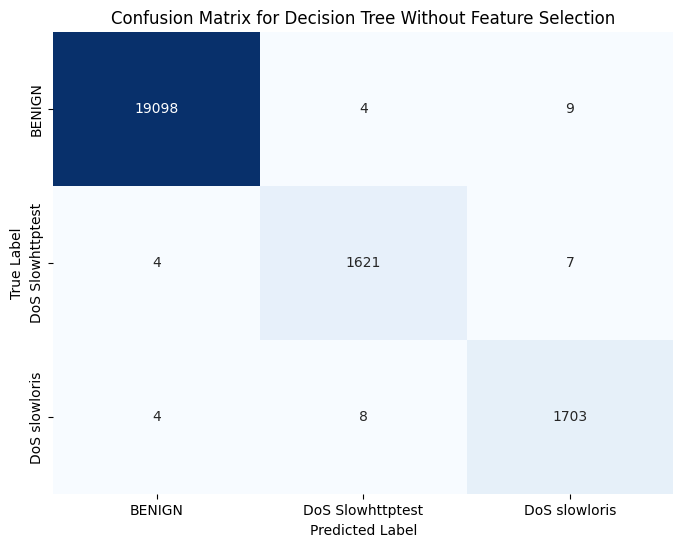

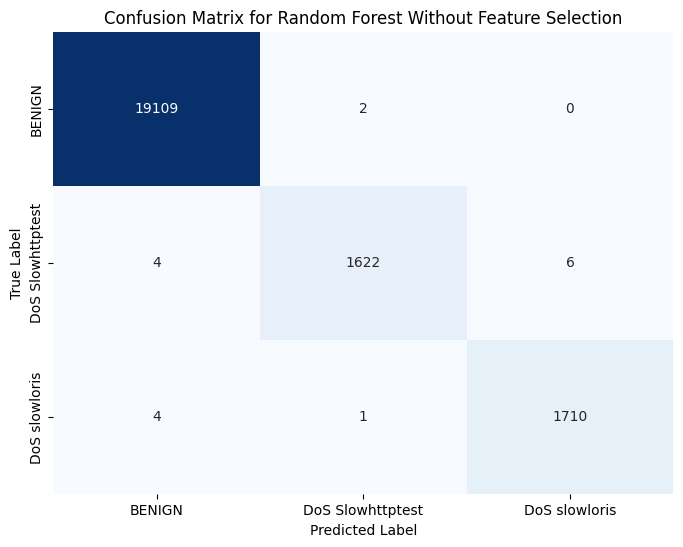

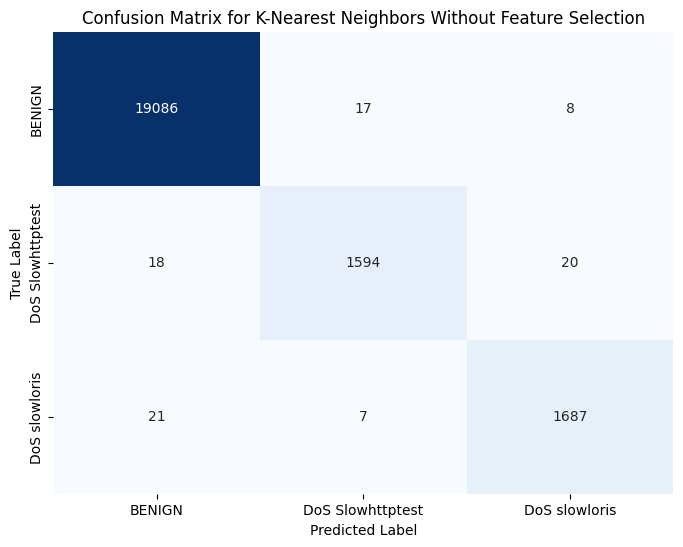

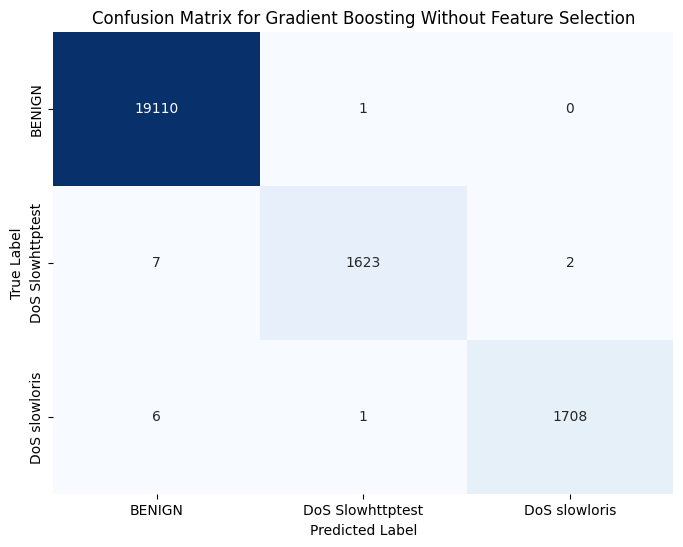

Top 20 features selected by SelectKBest with mutual information:
Index(['Total Length of Fwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Mean', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Min', 'Fwd IAT Min', 'Fwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'Average Packet Size',
       'Avg Fwd Segment Size', 'Fwd Header Length.1', 'Subflow Fwd Bytes',
       'Init_Win_bytes_forward', 'Active Min'],
      dtype='object')


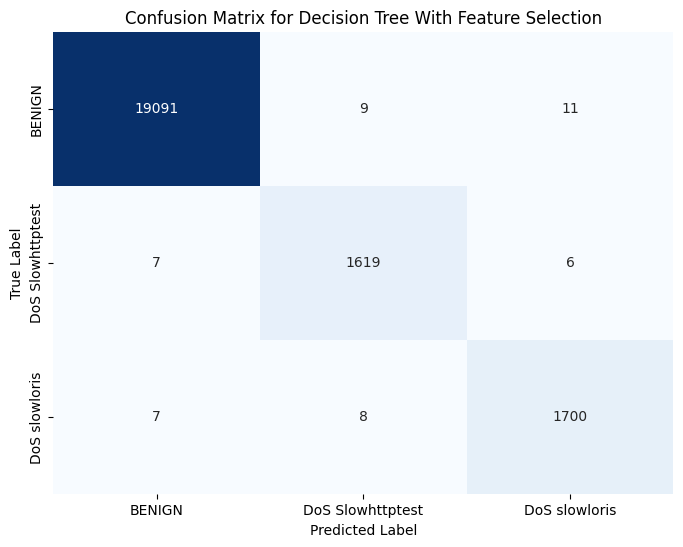

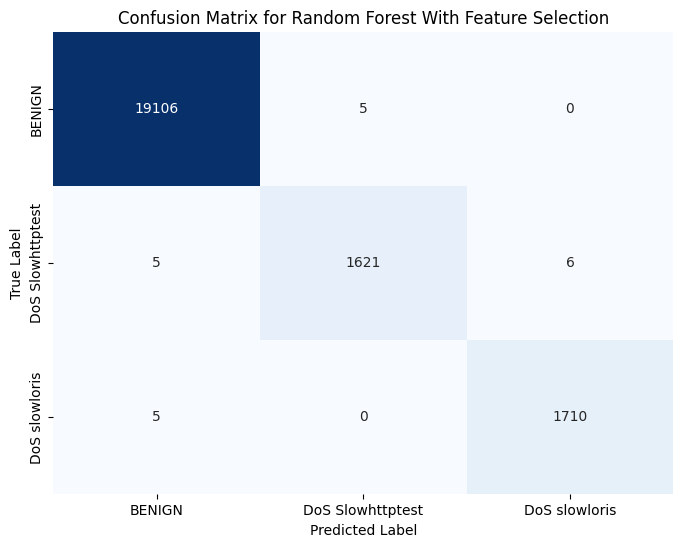

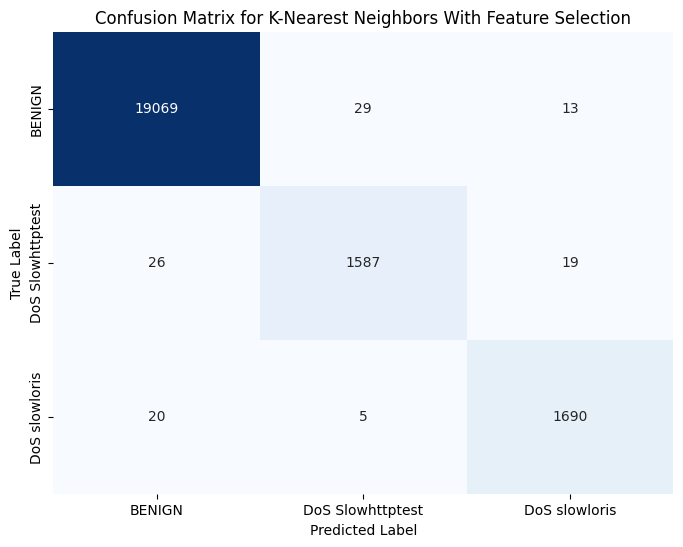

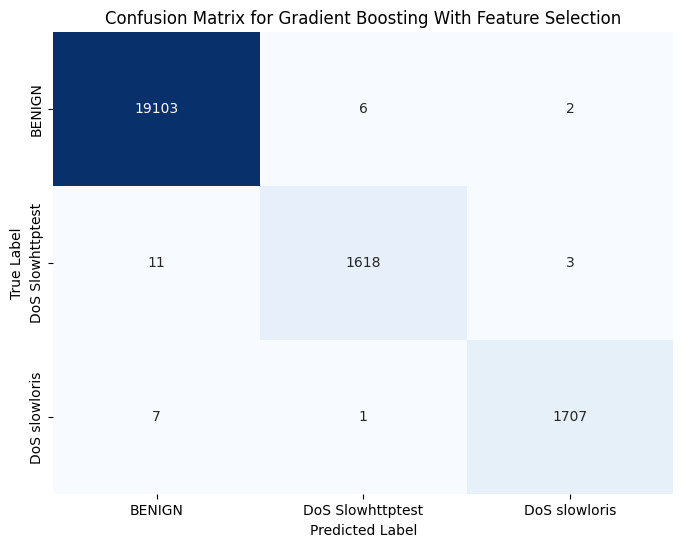

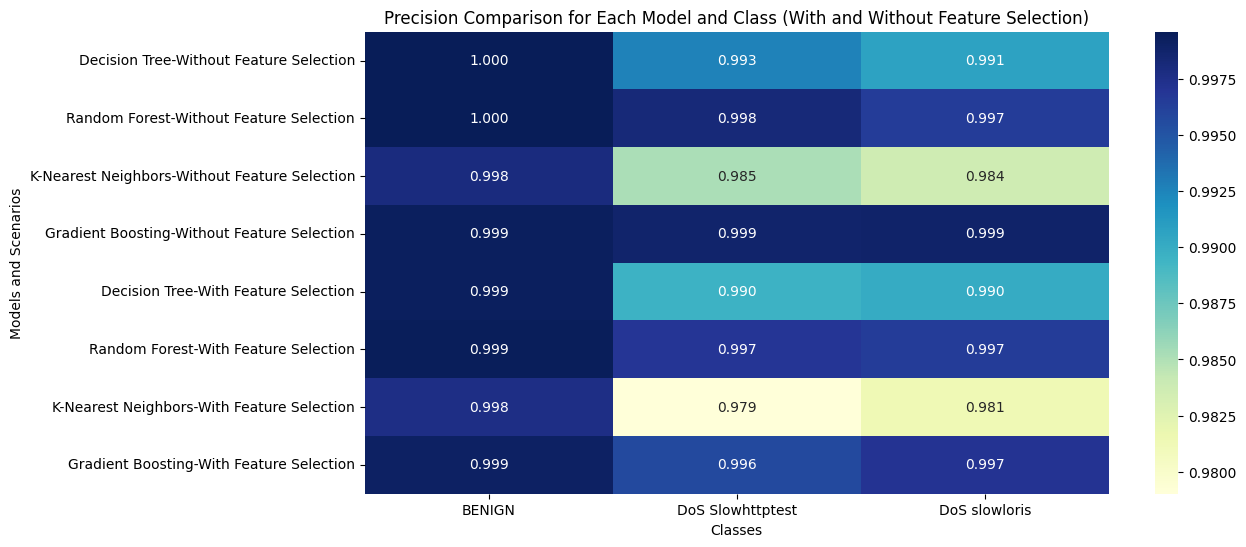

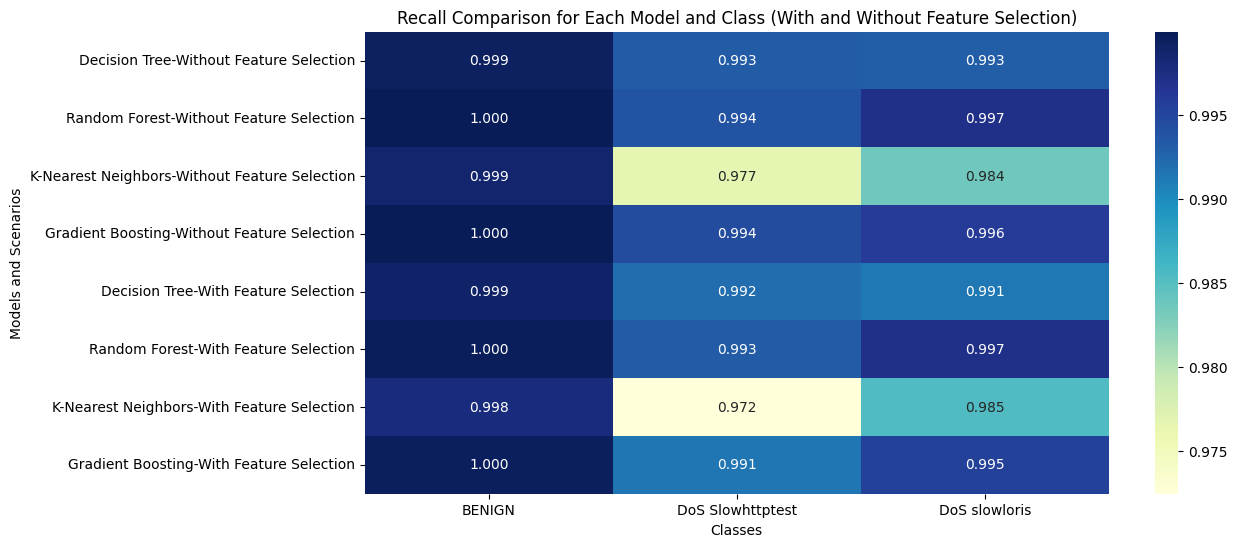

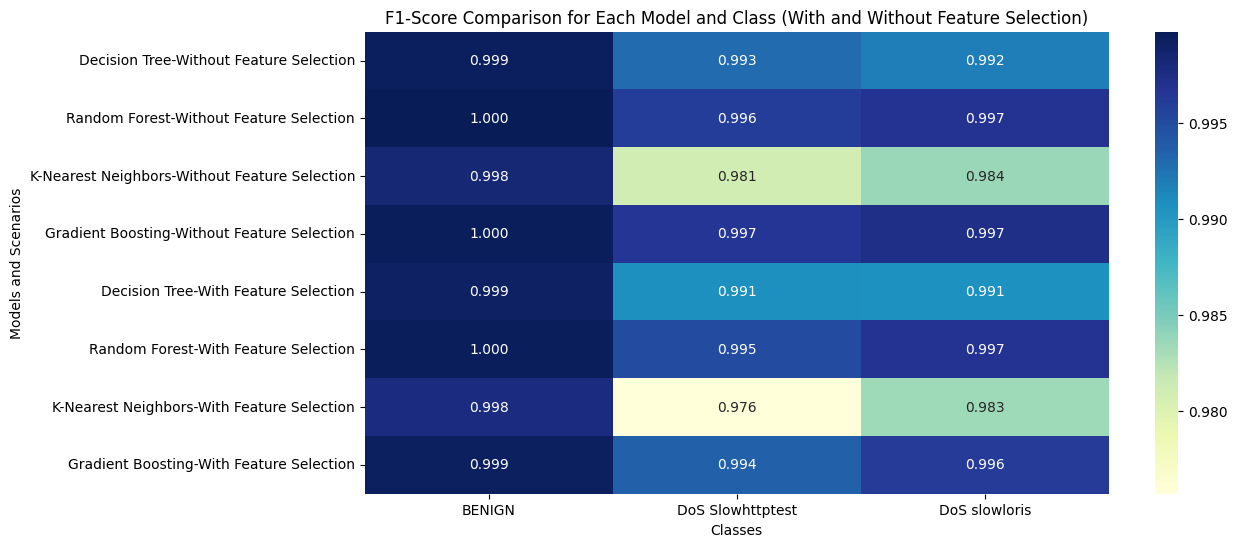

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Step 1: Load the Data
data = pd.read_csv('/kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv', nrows=75000)

# Strip leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Step 3: Filter for attacks with at least 1000 occurrences
label_counts = data['Label'].value_counts()
filtered_labels = label_counts[label_counts >= 1000].index
data = data[data['Label'].isin(filtered_labels)]

# Step 4: Handle Missing Values and Infinity Values
data_imputed = data.select_dtypes(include=['float64', 'int64'])

# Replace positive infinity, negative infinity, and excessively large values with NaN
data_imputed.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace large values (e.g., larger than 1e6) with NaN
data_imputed[data_imputed > 1e6] = np.nan

# Impute missing values (mean imputation for numeric columns)
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data_imputed))
data_imputed.columns = data.select_dtypes(include=['float64', 'int64']).columns

# Concatenate back the categorical columns
data_imputed = pd.concat([data_imputed, data.select_dtypes(include=['object']).reset_index(drop=True)], axis=1)

# Step 5: Convert Categorical Variables
label_encoders = {}
object_cols = data_imputed.select_dtypes(include=['object']).columns
for col in object_cols:
    le = LabelEncoder()
    data_imputed[col] = le.fit_transform(data_imputed[col])
    label_encoders[col] = le  # Save the encoder for future use

# Step 6: Prepare Features and Target Variable
X = data_imputed.drop(['Label'], axis=1)  # Features
y = data_imputed['Label']  # Target variable

# Get the class names mapping
class_names = label_encoders['Label'].inverse_transform(sorted(y.unique()))

# Step 7: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dictionary to store metrics for both scenarios
comparison_results = {
    'Model': [],
    'Scenario': [],  # With or Without Feature Selection
}

for class_name in class_names:
    comparison_results[f'Precision_{class_name}'] = []
    comparison_results[f'Recall_{class_name}'] = []
    comparison_results[f'F1_Score_{class_name}'] = []

# Models to Compare
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# ---- Without Feature Selection ----
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Classification report
    class_report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    
    # Store results
    comparison_results['Model'].append(model_name)
    comparison_results['Scenario'].append("Without Feature Selection")
    
    for class_name in class_names:
        if class_name in class_report:
            comparison_results[f'Precision_{class_name}'].append(class_report[class_name]['precision'])
            comparison_results[f'Recall_{class_name}'].append(class_report[class_name]['recall'])
            comparison_results[f'F1_Score_{class_name}'].append(class_report[class_name]['f1-score'])
        else:
            comparison_results[f'Precision_{class_name}'].append(0.0)
            comparison_results[f'Recall_{class_name}'].append(0.0)
            comparison_results[f'F1_Score_{class_name}'].append(0.0)
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.title(f"Confusion Matrix for {model_name} Without Feature Selection")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# ---- With Feature Selection ----
# Using SelectKBest with Mutual Information
selector = SelectKBest(mutual_info_classif, k=20)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Top 20 features selected by SelectKBest with mutual information:")
print(selected_features)

# Train models on selected features
for model_name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    # Classification report
    class_report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    
    # Store results
    comparison_results['Model'].append(model_name)
    comparison_results['Scenario'].append("With Feature Selection")
    
    for class_name in class_names:
        if class_name in class_report:
            comparison_results[f'Precision_{class_name}'].append(class_report[class_name]['precision'])
            comparison_results[f'Recall_{class_name}'].append(class_report[class_name]['recall'])
            comparison_results[f'F1_Score_{class_name}'].append(class_report[class_name]['f1-score'])
        else:
            comparison_results[f'Precision_{class_name}'].append(0.0)
            comparison_results[f'Recall_{class_name}'].append(0.0)
            comparison_results[f'F1_Score_{class_name}'].append(0.0)
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.title(f"Confusion Matrix for {model_name} With Feature Selection")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Convert comparison_results dictionary to DataFrame
comparison_df = pd.DataFrame(comparison_results)
comparison_df.set_index(['Model', 'Scenario'], inplace=True)

# Plot Heatmaps for Comparison
# Precision heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(comparison_df.filter(regex='Precision'), annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=class_names)
plt.title("Precision Comparison for Each Model and Class (With and Without Feature Selection)")
plt.xlabel("Classes")
plt.ylabel("Models and Scenarios")
plt.show()

# Recall heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(comparison_df.filter(regex='Recall'), annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=class_names)
plt.title("Recall Comparison for Each Model and Class (With and Without Feature Selection)")
plt.xlabel("Classes")
plt.ylabel("Models and Scenarios")
plt.show()

# F1-Score heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(comparison_df.filter(regex='F1_Score'), annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=class_names)
plt.title("F1-Score Comparison for Each Model and Class (With and Without Feature Selection)")
plt.xlabel("Classes")
plt.ylabel("Models and Scenarios")
plt.show()


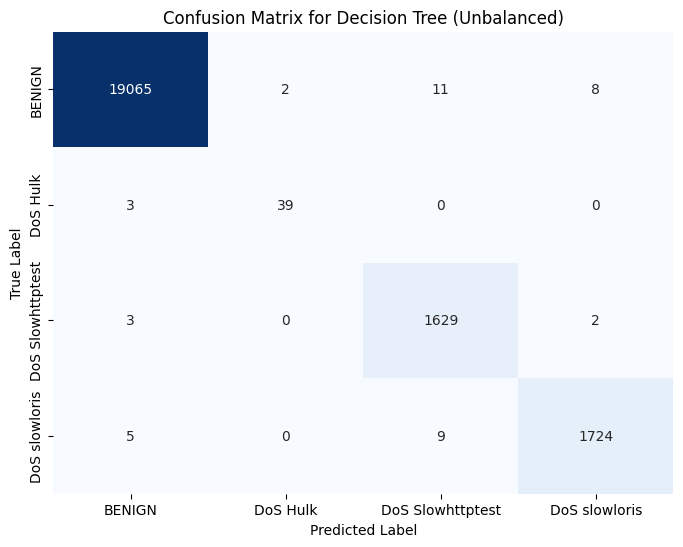

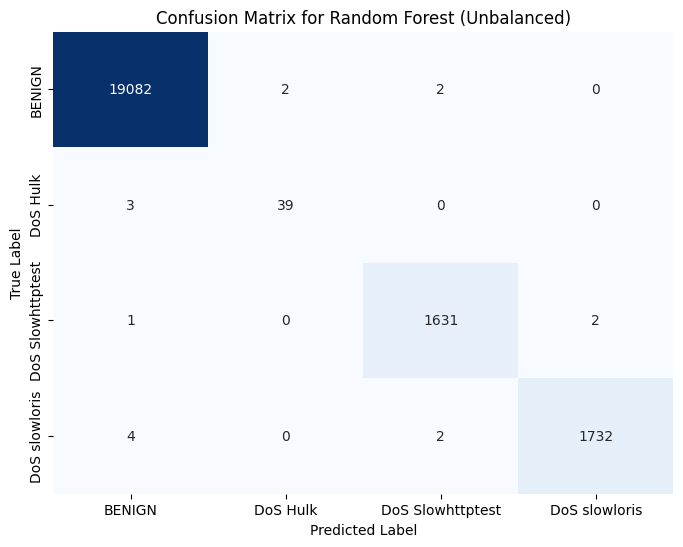

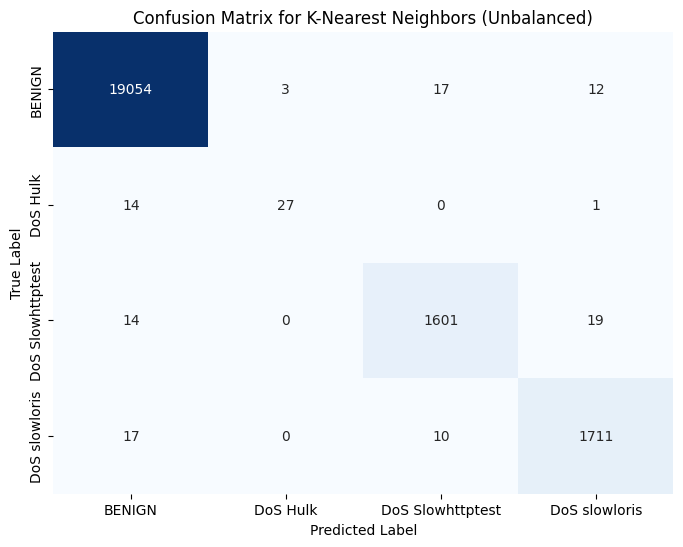

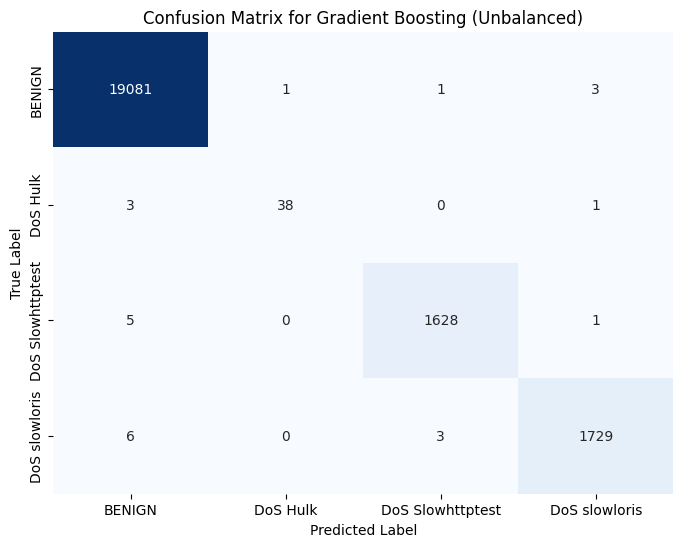

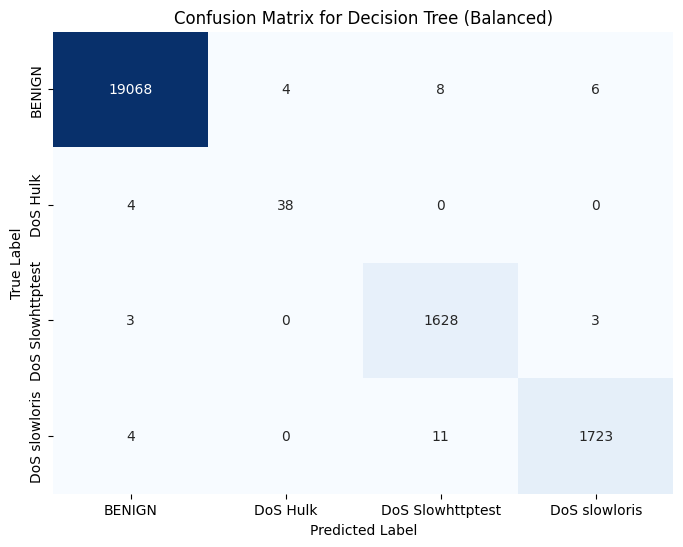

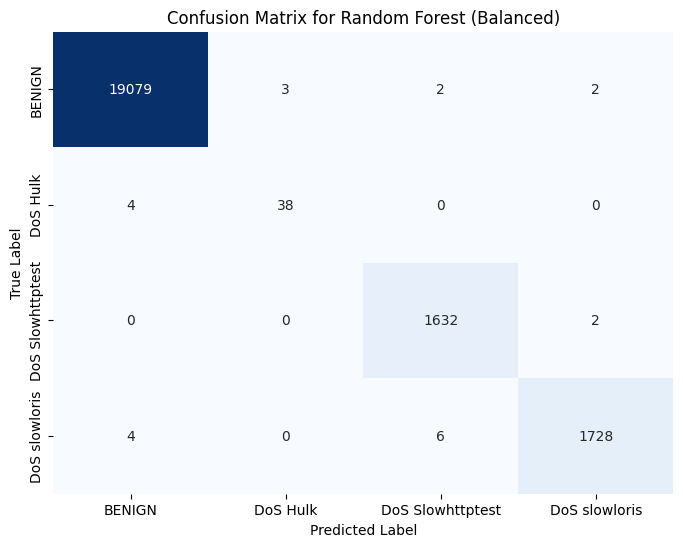

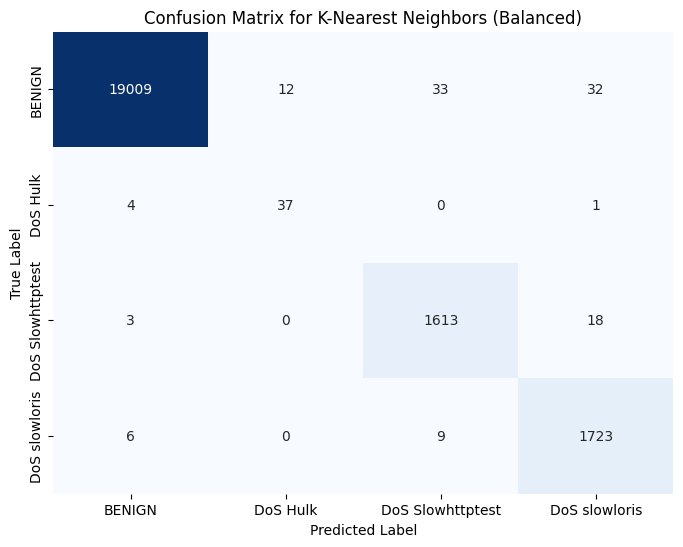

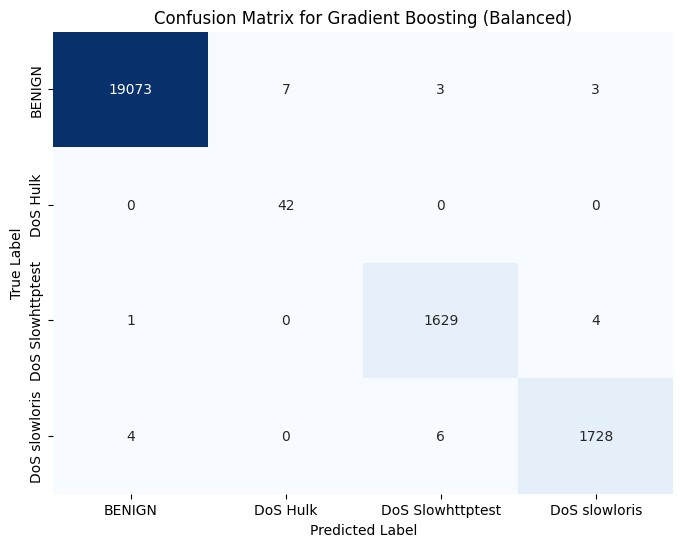

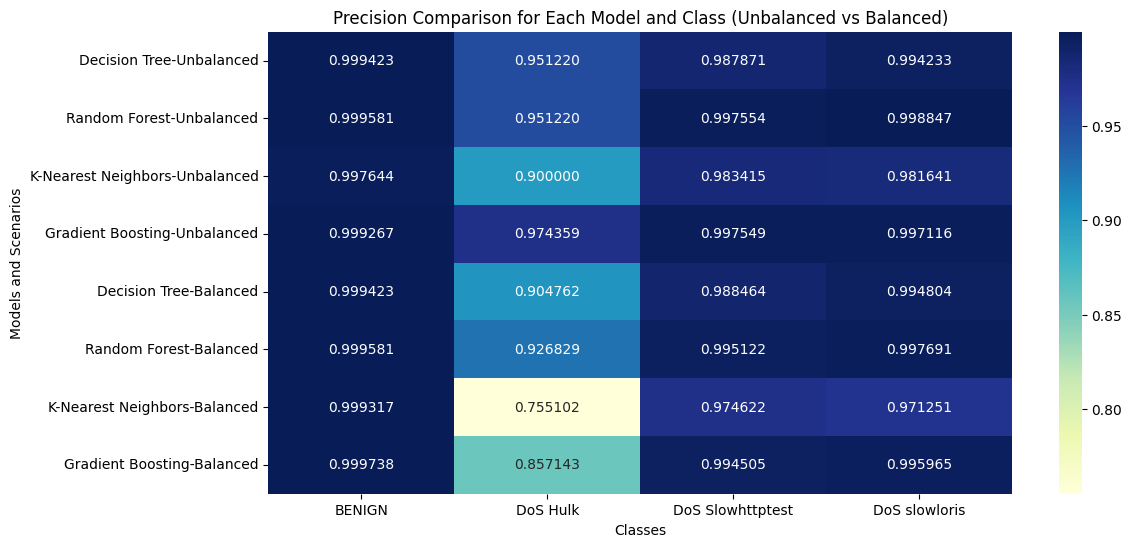

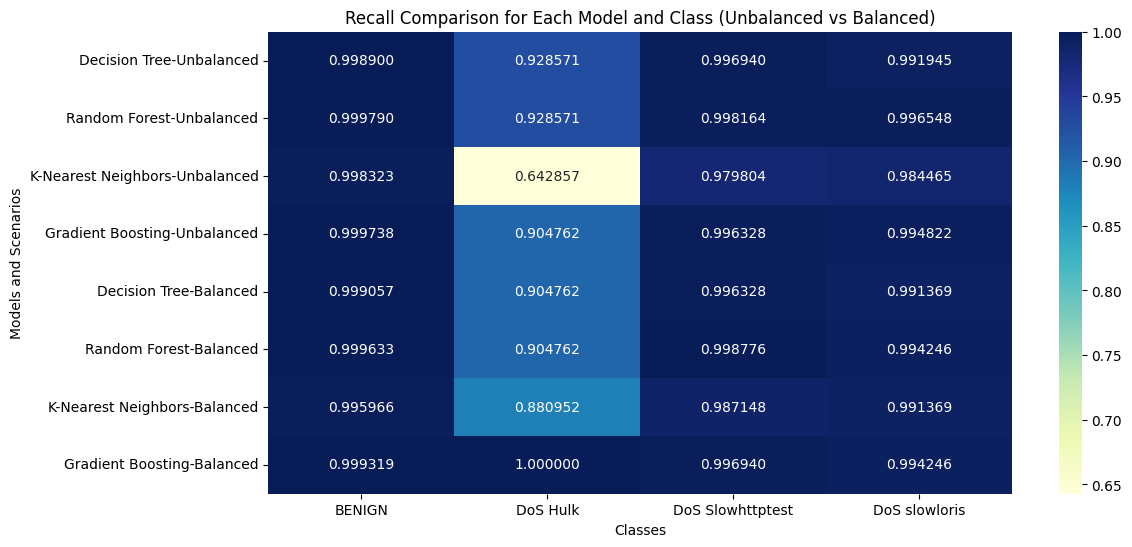

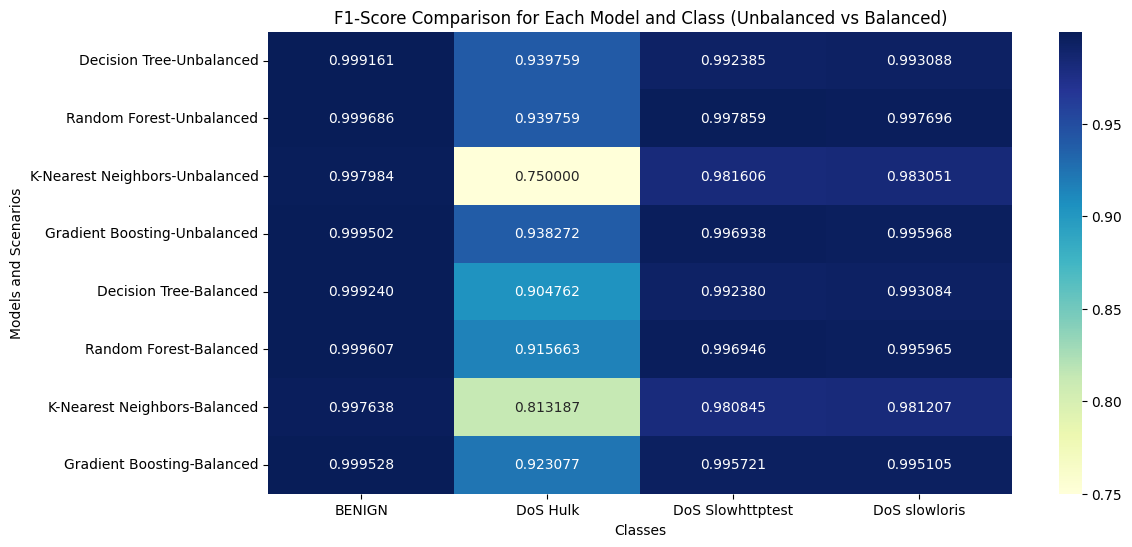

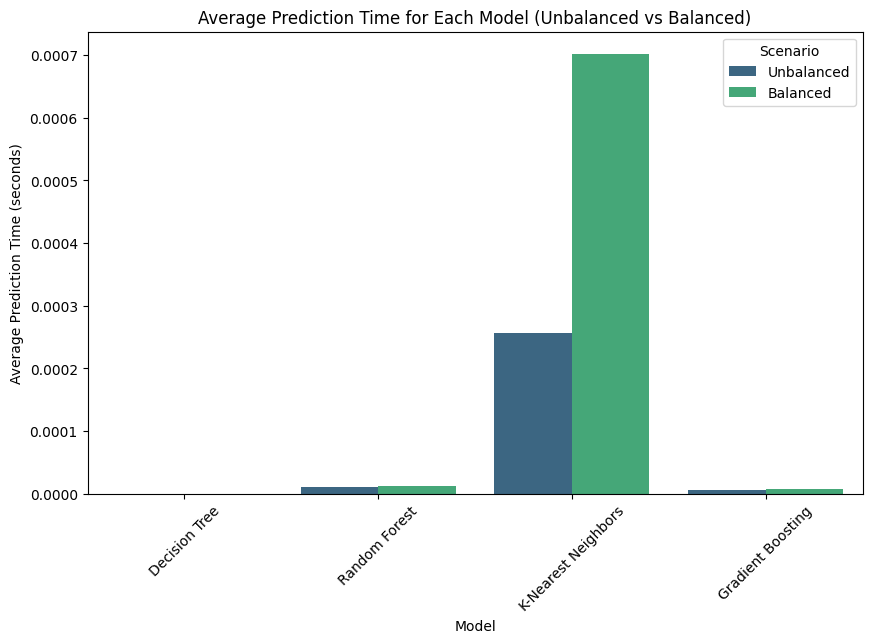

In [35]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE

# Step 1: Load the Data
data = pd.read_csv('/kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv', nrows=75000)

# Step 2: Strip leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Step 3: Handle Missing Values and Infinity Values
data_imputed = data.select_dtypes(include=['float64', 'int64'])

# Replace positive infinity, negative infinity, and excessively large values with NaN
data_imputed.replace([np.inf, -np.inf], np.nan, inplace=True)
data_imputed[data_imputed > 1e6] = np.nan

# Impute missing values (mean imputation for numeric columns)
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data_imputed))
data_imputed.columns = data.select_dtypes(include=['float64', 'int64']).columns

# Concatenate back the categorical columns
data_imputed = pd.concat([data_imputed, data.select_dtypes(include=['object']).reset_index(drop=True)], axis=1)

# Step 4: Convert Categorical Variables
label_encoders = {}
object_cols = data_imputed.select_dtypes(include=['object']).columns
for col in object_cols:
    le = LabelEncoder()
    data_imputed[col] = le.fit_transform(data_imputed[col])
    label_encoders[col] = le  # Save the encoder for future use

# Step 5: Prepare Features and Target Variable
X = data_imputed.drop(['Label'], axis=1)  # Features
y = data_imputed['Label']  # Target variable

# Get the class names mapping
class_names = label_encoders['Label'].inverse_transform(sorted(y.unique()))

# Step 6: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 7: Balance the Dataset Using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Dictionary to store metrics for both scenarios
comparison_results = {
    'Model': [],
    'Scenario': [],  # Unbalanced or Balanced
    'Avg_Prediction_Time': [],
}

for class_name in class_names:
    comparison_results[f'Precision_{class_name}'] = []
    comparison_results[f'Recall_{class_name}'] = []
    comparison_results[f'F1_Score_{class_name}'] = []

# Models to Compare
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Function to Evaluate Models
def evaluate_models(X_train, X_test, y_train, y_test, scenario):
    for model_name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        
        # Measure prediction time
        start_time = time.time()
        y_pred = model.predict(X_test)
        end_time = time.time()
        
        # Compute average prediction time
        avg_time = (end_time - start_time) / len(X_test)
        
        # Classification report
        class_report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
        
        # Store results
        comparison_results['Model'].append(model_name)
        comparison_results['Scenario'].append(scenario)
        comparison_results['Avg_Prediction_Time'].append(avg_time)
        
        for class_name in class_names:
            if class_name in class_report:
                comparison_results[f'Precision_{class_name}'].append(class_report[class_name]['precision'])
                comparison_results[f'Recall_{class_name}'].append(class_report[class_name]['recall'])
                comparison_results[f'F1_Score_{class_name}'].append(class_report[class_name]['f1-score'])
            else:
                comparison_results[f'Precision_{class_name}'].append(0.0)
                comparison_results[f'Recall_{class_name}'].append(0.0)
                comparison_results[f'F1_Score_{class_name}'].append(0.0)
        
        # Plot Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
        plt.title(f"Confusion Matrix for {model_name} ({scenario})")
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

# ---- Evaluate Models for Unbalanced Dataset ----
evaluate_models(X_train, X_test, y_train, y_test, "Unbalanced")

# ---- Evaluate Models for Balanced Dataset ----
evaluate_models(X_train_balanced, X_test, y_train_balanced, y_test, "Balanced")

# Convert comparison_results dictionary to DataFrame
comparison_df = pd.DataFrame(comparison_results)
comparison_df.set_index(['Model', 'Scenario'], inplace=True)

# Plot Heatmaps for Comparison
# Precision heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(comparison_df.filter(regex='Precision'), annot=True, cmap='YlGnBu', fmt=".6f", xticklabels=class_names)
plt.title("Precision Comparison for Each Model and Class (Unbalanced vs Balanced)")
plt.xlabel("Classes")
plt.ylabel("Models and Scenarios")
plt.show()

# Recall heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(comparison_df.filter(regex='Recall'), annot=True, cmap='YlGnBu', fmt=".6f", xticklabels=class_names)
plt.title("Recall Comparison for Each Model and Class (Unbalanced vs Balanced)")
plt.xlabel("Classes")
plt.ylabel("Models and Scenarios")
plt.show()

# F1-Score heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(comparison_df.filter(regex='F1_Score'), annot=True, cmap='YlGnBu', fmt=".6f", xticklabels=class_names)
plt.title("F1-Score Comparison for Each Model and Class (Unbalanced vs Balanced)")
plt.xlabel("Classes")
plt.ylabel("Models and Scenarios")
plt.show()

# Bar plot for average prediction time comparison
avg_time_df = comparison_df.reset_index()[['Model', 'Scenario', 'Avg_Prediction_Time']].drop_duplicates()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_time_df,
    x="Model",
    y="Avg_Prediction_Time",
    hue="Scenario",
    palette="viridis"
)
plt.title("Average Prediction Time for Each Model (Unbalanced vs Balanced)")
plt.xlabel("Model")
plt.ylabel("Average Prediction Time (seconds)")
plt.xticks(rotation=45)
plt.show()


# **Hybrid**

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Prediction Time (No Feature Selection): 5.73s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Prediction Time (With Feature Selection): 4.63s


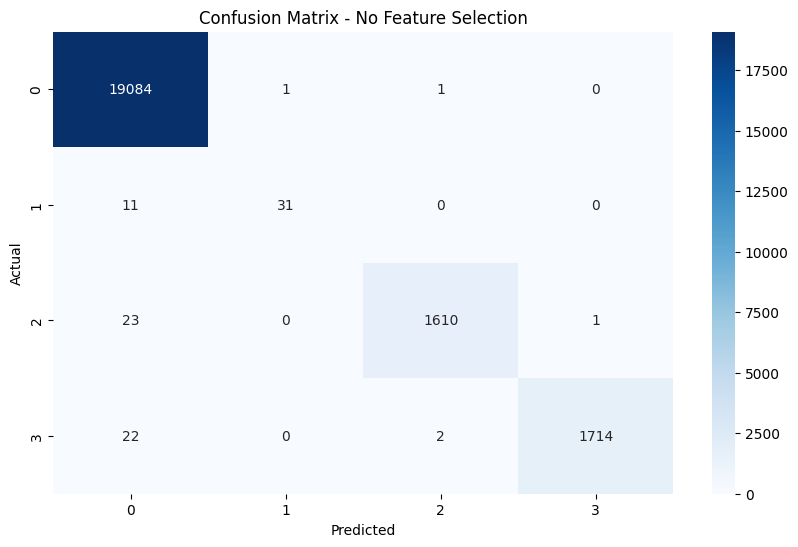

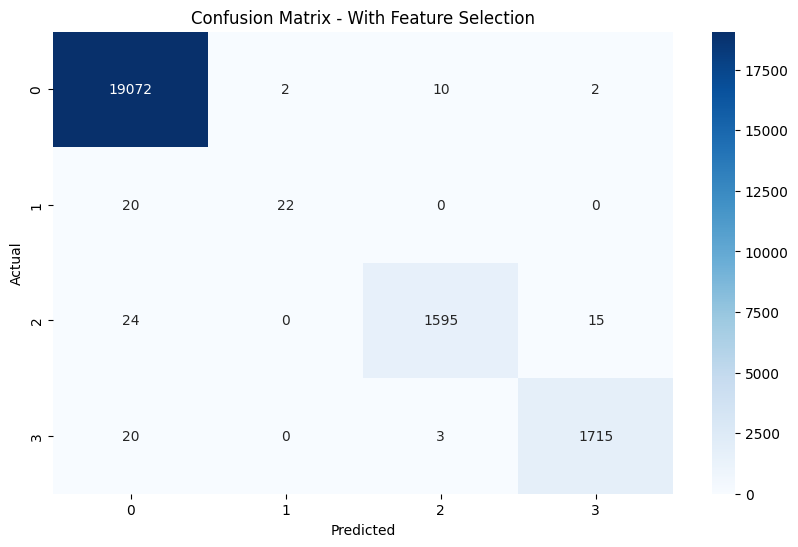

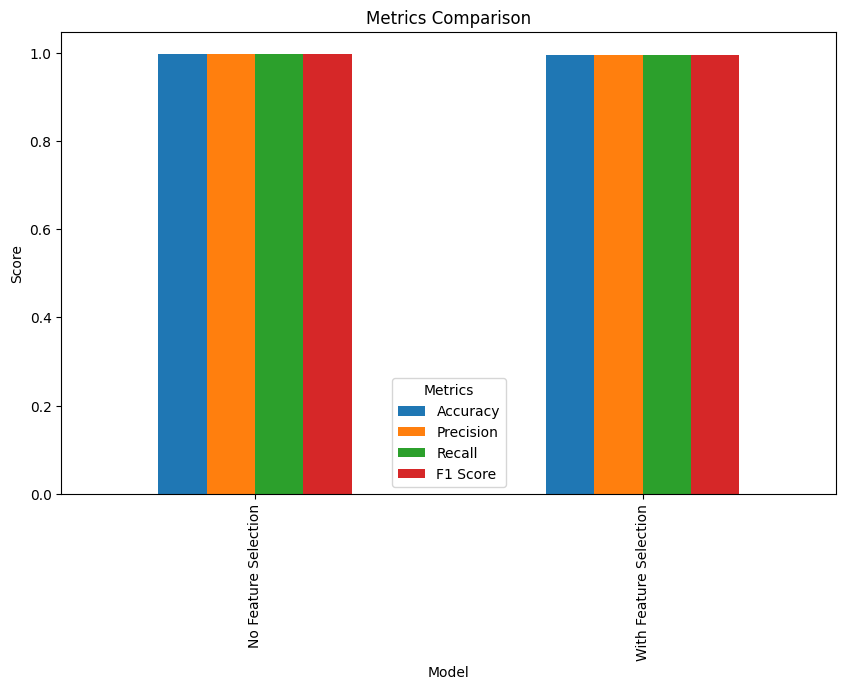

In [36]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Step 1: Load the Data
data = pd.read_csv('/kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv', nrows=75000)

# Step 2: Strip Leading/Trailing Spaces from Column Names
data.columns = data.columns.str.strip()

# Step 3: Specify Target Column
target_column = 'Label'  # Replace 'Label' with the actual target column name if different
class_counts = data[target_column].value_counts()


# Step 5: Handle Missing Values and Infinity Values
# Select numeric columns for preprocessing
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Replace positive/negative infinity and large values with NaN
numeric_data.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_data[numeric_data > 1e6] = np.nan

# Impute missing values using the mean
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(numeric_data), columns=numeric_data.columns)

# Combine with categorical data
categorical_data = data.select_dtypes(include=['object']).reset_index(drop=True)
data_cleaned = pd.concat([data_imputed, categorical_data], axis=1)

# Step 6: Encode Categorical Variables
label_encoders = {}
for col in categorical_data.columns:
    le = LabelEncoder()
    data_cleaned[col] = le.fit_transform(data_cleaned[col])
    label_encoders[col] = le

# Step 7: Define Features and Target
X = data_cleaned.drop(columns=[target_column])
y = data_cleaned[target_column]

# Step 8: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 9: Define Models
lr_model = LogisticRegression(max_iter=1000)
knn_model = KNeighborsClassifier()
rf_model = RandomForestClassifier()

ensemble_model = VotingClassifier(estimators=[
    ('lr', lr_model),
    ('knn', knn_model),
    ('rf', rf_model)
], voting='hard')

# Without Feature Selection
ensemble_model.fit(X_train, y_train)
start_time = time.time()
y_pred_no_fs = ensemble_model.predict(X_test)
predict_time_no_fs = time.time() - start_time
print(f"Prediction Time (No Feature Selection): {predict_time_no_fs:.2f}s")

# Feature Selection
selector = SelectKBest(mutual_info_classif, k=20)
X_train_fs = selector.fit_transform(X_train, y_train)
X_test_fs = selector.transform(X_test)

ensemble_model.fit(X_train_fs, y_train)
start_time = time.time()
y_pred_fs = ensemble_model.predict(X_test_fs)
predict_time_fs = time.time() - start_time
print(f"Prediction Time (With Feature Selection): {predict_time_fs:.2f}s")

# Metrics Comparison
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'No Feature Selection': [
        accuracy_score(y_test, y_pred_no_fs),
        *precision_recall_fscore_support(y_test, y_pred_no_fs, average='weighted')[:3]
    ],
    'With Feature Selection': [
        accuracy_score(y_test, y_pred_fs),
        *precision_recall_fscore_support(y_test, y_pred_fs, average='weighted')[:3]
    ]
})

# Confusion Matrices
cm_no_fs = confusion_matrix(y_test, y_pred_no_fs)
cm_fs = confusion_matrix(y_test, y_pred_fs)

# Visualizations
plt.figure(figsize=(10, 6))
sns.heatmap(cm_no_fs, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - No Feature Selection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(cm_fs, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - With Feature Selection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot Metrics Comparison
metrics_df.set_index('Metric').T.plot(kind='bar', figsize=(10, 6))
plt.title("Metrics Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(title="Metrics")
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Prediction time without feature selection: 5.70 seconds
Average Time to Detect an Attack per Sample without Feature Selection: 0.000253 seconds


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Prediction time with feature selection: 3.87 seconds
Average Time to Detect an Attack per Sample with Feature Selection: 0.000172 seconds

Model Performance Metrics Comparison:
                           Accuracy  Precision    Recall  F1 Score  \
Without Feature Selection  0.997289   0.997280  0.997289  0.997247   
With Feature Selection     0.995733   0.995662  0.995733  0.995591   

                           Average Time to Detect (seconds)  
Without Feature Selection                          0.000253  
With Feature Selection                             0.000172  


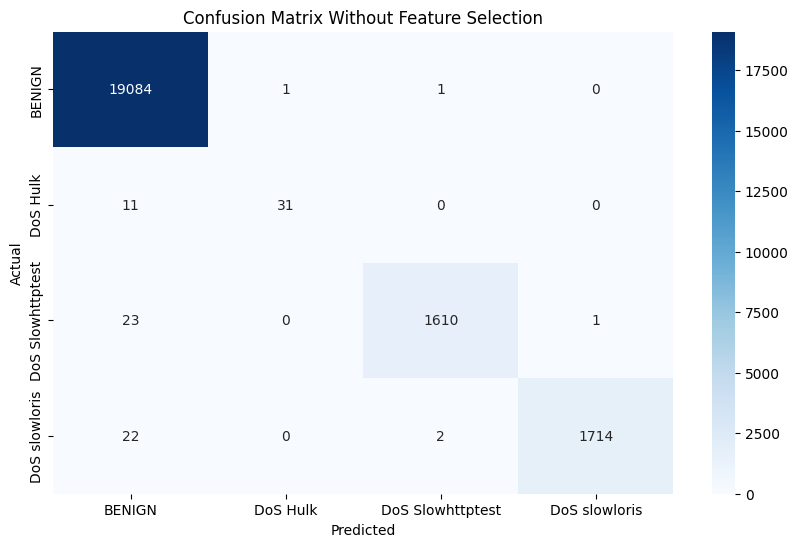

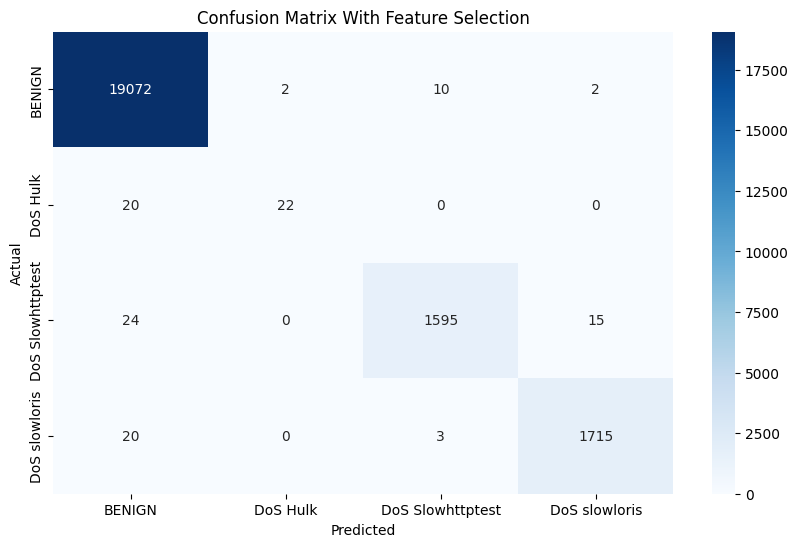

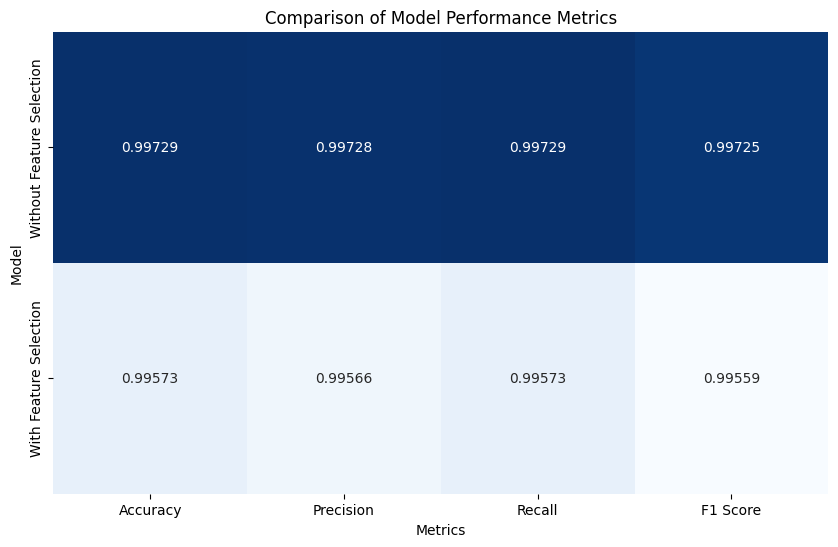

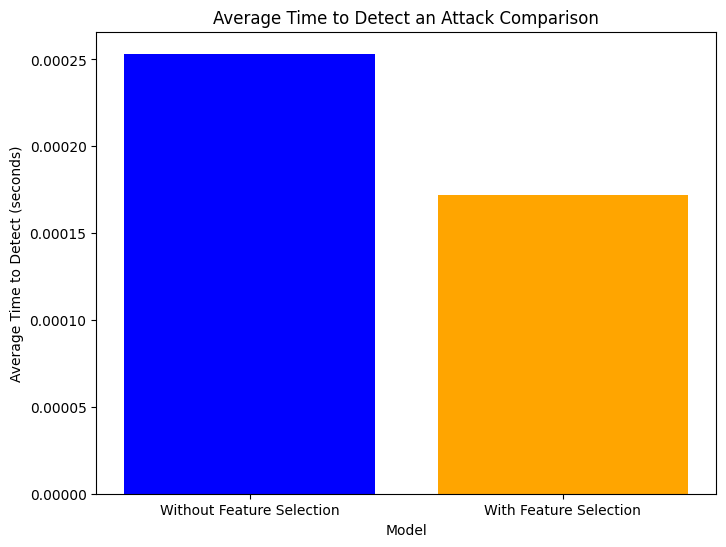

In [37]:
# ---- Without Feature Selection ----
# Fit the model without feature selection
ensemble_model.fit(X_train, y_train)

# Start the timer just before making predictions
predict_start = time.time()

# Make predictions without feature selection
y_pred_without_fs = ensemble_model.predict(X_test)

# Calculate and print the time taken for prediction
predict_time_without_fs = time.time() - predict_start
print(f"Prediction time without feature selection: {predict_time_without_fs:.2f} seconds")

# Calculate the time per attack detection (individual sample prediction time)
time_per_sample_without_fs = predict_time_without_fs / len(X_test)
print(f"Average Time to Detect an Attack per Sample without Feature Selection: {time_per_sample_without_fs:.6f} seconds")

# ---- With Feature Selection ----
# Feature selection
selector = SelectKBest(mutual_info_classif, k=20)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Fit the model on selected features
ensemble_model.fit(X_train_selected, y_train)

# Start the timer just before making predictions with selected features
predict_start = time.time()

# Make predictions with selected features
y_pred_with_fs = ensemble_model.predict(X_test_selected)

# Calculate and print the time taken for prediction
predict_time_with_fs = time.time() - predict_start
print(f"Prediction time with feature selection: {predict_time_with_fs:.2f} seconds")

# Calculate the time per attack detection (individual sample prediction time)
time_per_sample_with_fs = predict_time_with_fs / len(X_test_selected)
print(f"Average Time to Detect an Attack per Sample with Feature Selection: {time_per_sample_with_fs:.6f} seconds")

# --- Metrics Comparison ---
# Calculate and print metrics for comparison
accuracy_without_fs = accuracy_score(y_test, y_pred_without_fs)
precision_without_fs, recall_without_fs, f1_without_fs, _ = precision_recall_fscore_support(y_test, y_pred_without_fs, average='weighted')

accuracy_with_fs = accuracy_score(y_test, y_pred_with_fs)
precision_with_fs, recall_with_fs, f1_with_fs, _ = precision_recall_fscore_support(y_test, y_pred_with_fs, average='weighted')

# Create a dataframe for performance metrics comparison
metrics_df = pd.DataFrame({
    'Accuracy': [accuracy_without_fs, accuracy_with_fs],
    'Precision': [precision_without_fs, precision_with_fs],
    'Recall': [recall_without_fs, recall_with_fs],
    'F1 Score': [f1_without_fs, f1_with_fs],
    'Average Time to Detect (seconds)': [time_per_sample_without_fs, time_per_sample_with_fs]
}, index=['Without Feature Selection', 'With Feature Selection'])

print("\nModel Performance Metrics Comparison:")
print(metrics_df)

# --- Confusion Matrix Comparison ---
cm_without_fs = confusion_matrix(y_test, y_pred_without_fs)
cm_with_fs = confusion_matrix(y_test, y_pred_with_fs)

# Plot Confusion Matrix without Feature Selection
plt.figure(figsize=(10, 6))
sns.heatmap(cm_without_fs, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix Without Feature Selection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot Confusion Matrix with Feature Selection
plt.figure(figsize=(10, 6))
sns.heatmap(cm_with_fs, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix With Feature Selection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Plot Metrics Comparison ---
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']], annot=True, cmap="Blues", fmt=".5f", cbar=False)
plt.title("Comparison of Model Performance Metrics")
plt.ylabel('Model')
plt.xlabel('Metrics')
plt.show()

# --- Plot Average Time to Detect Comparison ---
plt.figure(figsize=(8, 6))
plt.bar(metrics_df.index, metrics_df['Average Time to Detect (seconds)'], color=['blue', 'orange'])
plt.title("Average Time to Detect an Attack Comparison")
plt.xlabel('Model')
plt.ylabel('Average Time to Detect (seconds)')
plt.show()


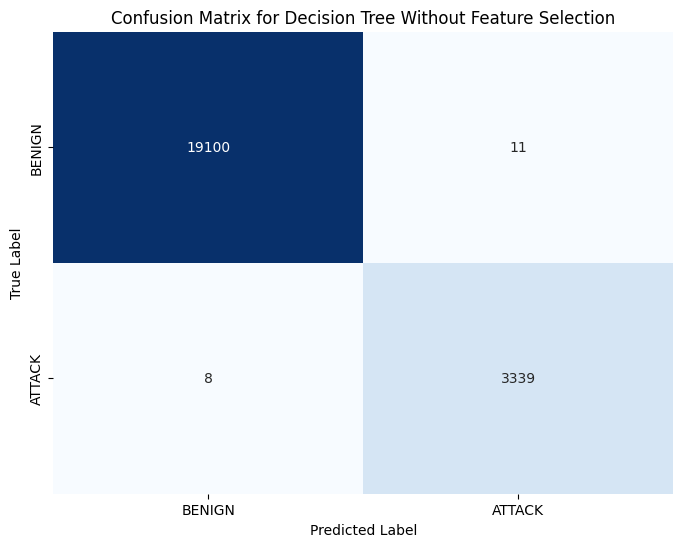

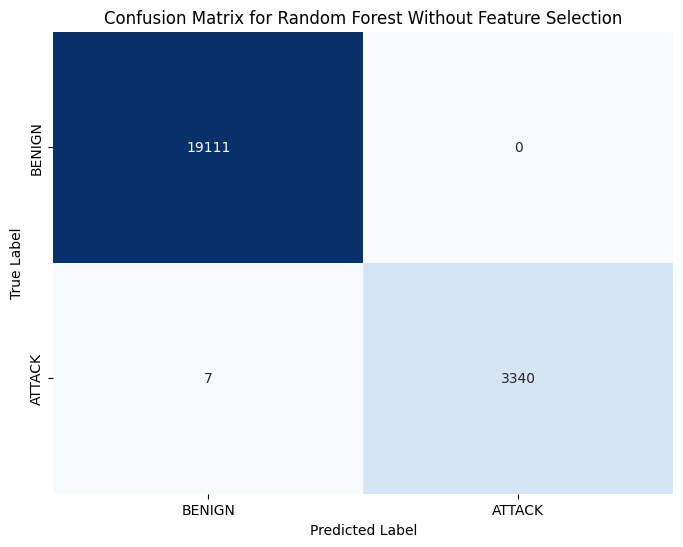

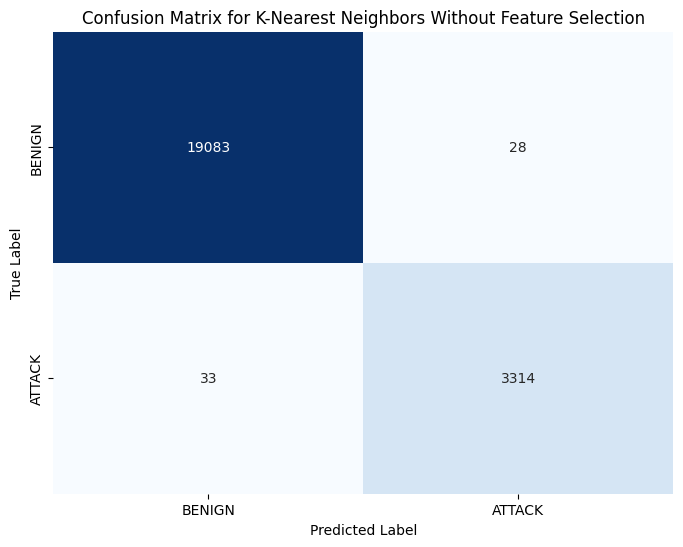

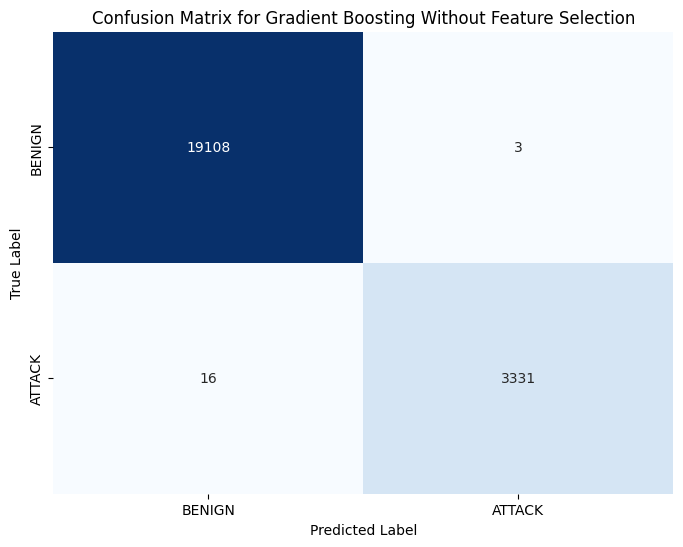

Top 20 features selected by SelectKBest with mutual information:
Index(['Destination Port', 'Total Length of Fwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Min', 'Fwd IAT Min', 'Fwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'Average Packet Size', 'Avg Fwd Segment Size', 'Fwd Header Length.1',
       'Subflow Fwd Bytes', 'Init_Win_bytes_forward'],
      dtype='object')


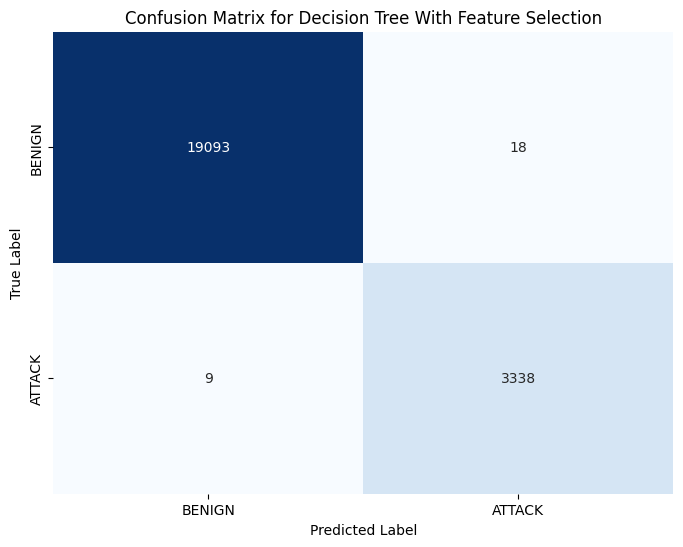

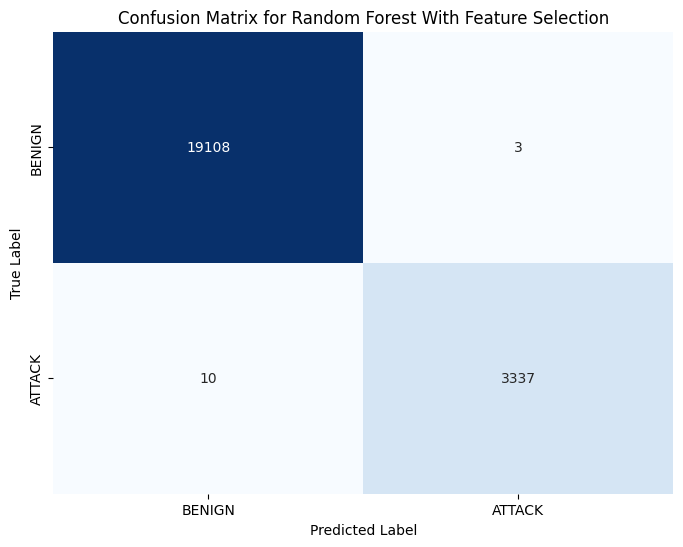

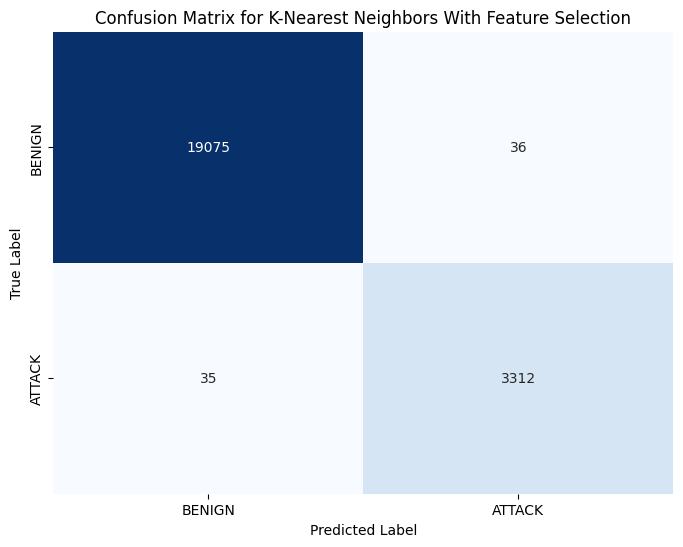

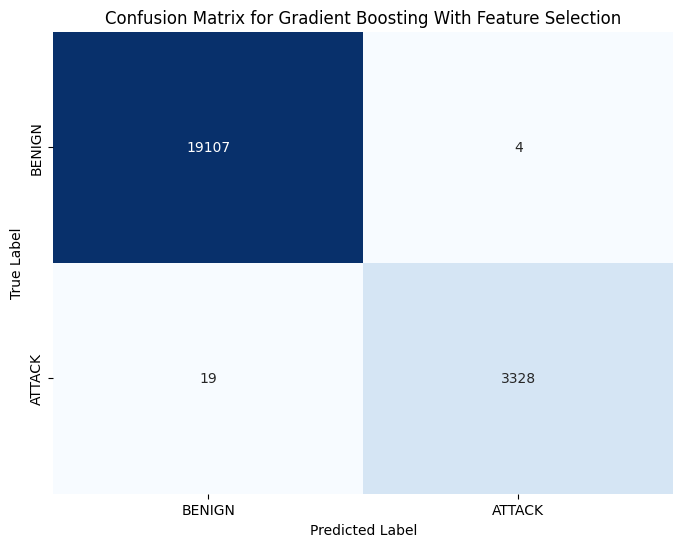

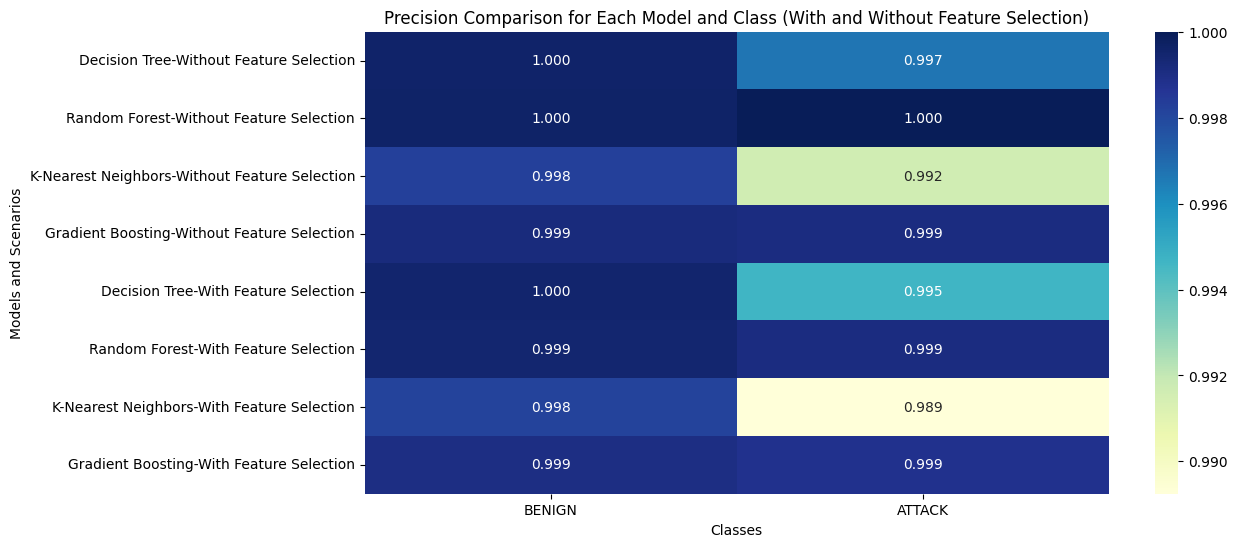

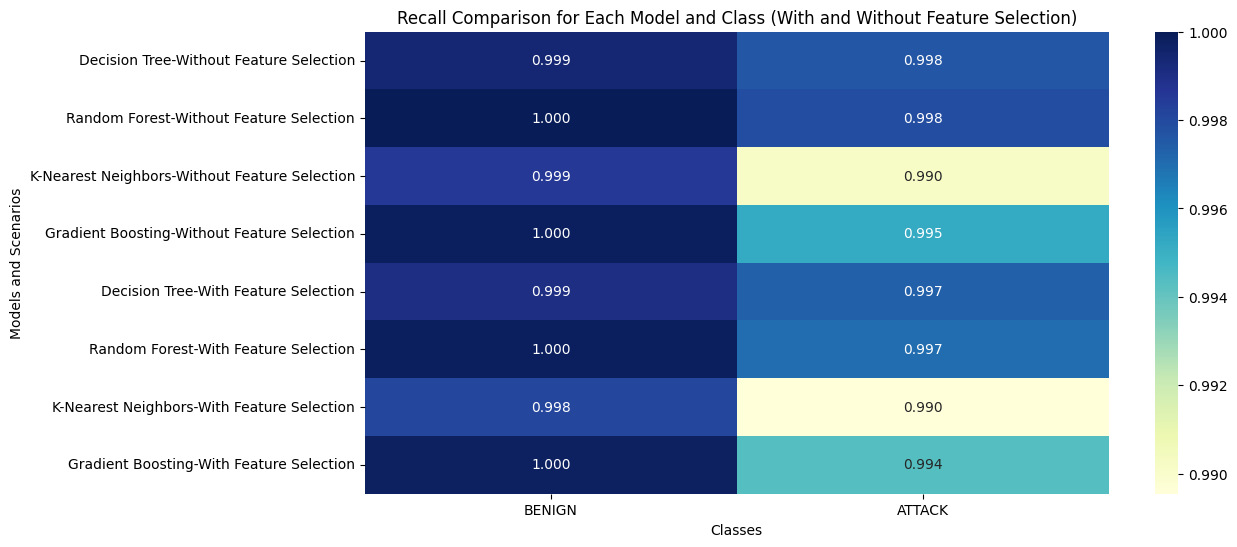

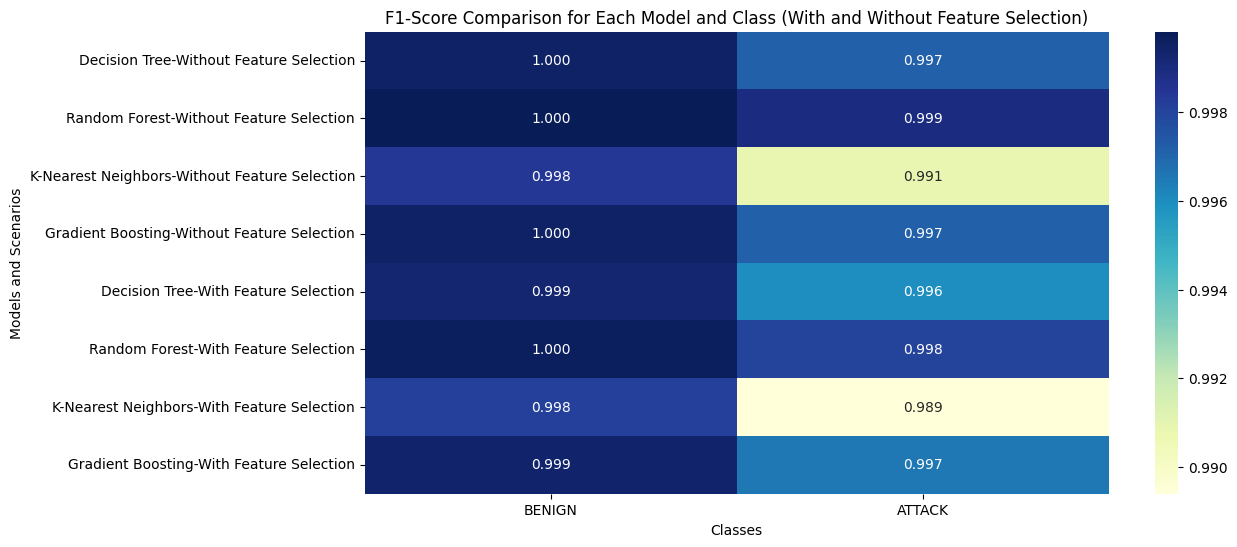

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Step 1: Load the Data
data = pd.read_csv('/kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv', nrows=75000)

# Strip leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Step 3: Filter for attacks with at least 1000 occurrences
label_counts = data['Label'].value_counts()
filtered_labels = label_counts[label_counts >= 1000].index
data = data[data['Label'].isin(filtered_labels)]

# Step 4: Handle Missing Values and Infinity Values
data_imputed = data.select_dtypes(include=['float64', 'int64'])

# Replace positive infinity, negative infinity, and excessively large values with NaN
data_imputed.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace large values (e.g., larger than 1e6) with NaN
data_imputed[data_imputed > 1e6] = np.nan

# Impute missing values (mean imputation for numeric columns)
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data_imputed))
data_imputed.columns = data.select_dtypes(include=['float64', 'int64']).columns

# Concatenate back the categorical columns
data_imputed = pd.concat([data_imputed, data.select_dtypes(include=['object']).reset_index(drop=True)], axis=1)

# Step 5: Convert Categorical Variables
# Convert "Label" to binary (0 = BENIGN, 1 = ATTACK)
data_imputed['Label'] = data_imputed['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

# Convert other categorical columns to numeric
label_encoders = {}
object_cols = data_imputed.select_dtypes(include=['object']).columns
for col in object_cols:
    le = LabelEncoder()
    data_imputed[col] = le.fit_transform(data_imputed[col])
    label_encoders[col] = le  # Save the encoder for future use

# Step 6: Prepare Features and Target Variable
X = data_imputed.drop(['Label'], axis=1)  # Features
y = data_imputed['Label']  # Target variable

# Get the class names mapping (only 0 and 1 for binary classification)
class_names = ['BENIGN', 'ATTACK']

# Step 7: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dictionary to store metrics for both scenarios
comparison_results = {
    'Model': [],
    'Scenario': [],  # With or Without Feature Selection
}

for class_name in class_names:
    comparison_results[f'Precision_{class_name}'] = []
    comparison_results[f'Recall_{class_name}'] = []
    comparison_results[f'F1_Score_{class_name}'] = []

# Models to Compare
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# ---- Without Feature Selection ----
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Classification report
    class_report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    
    # Store results
    comparison_results['Model'].append(model_name)
    comparison_results['Scenario'].append("Without Feature Selection")
    
    for class_name in class_names:
        if class_name in class_report:
            comparison_results[f'Precision_{class_name}'].append(class_report[class_name]['precision'])
            comparison_results[f'Recall_{class_name}'].append(class_report[class_name]['recall'])
            comparison_results[f'F1_Score_{class_name}'].append(class_report[class_name]['f1-score'])
        else:
            comparison_results[f'Precision_{class_name}'].append(0.0)
            comparison_results[f'Recall_{class_name}'].append(0.0)
            comparison_results[f'F1_Score_{class_name}'].append(0.0)
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.title(f"Confusion Matrix for {model_name} Without Feature Selection")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# ---- With Feature Selection ----
# Using SelectKBest with Mutual Information
selector = SelectKBest(mutual_info_classif, k=20)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Top 20 features selected by SelectKBest with mutual information:")
print(selected_features)

# Train models on selected features
for model_name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    # Classification report
    class_report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    
    # Store results
    comparison_results['Model'].append(model_name)
    comparison_results['Scenario'].append("With Feature Selection")
    
    for class_name in class_names:
        if class_name in class_report:
            comparison_results[f'Precision_{class_name}'].append(class_report[class_name]['precision'])
            comparison_results[f'Recall_{class_name}'].append(class_report[class_name]['recall'])
            comparison_results[f'F1_Score_{class_name}'].append(class_report[class_name]['f1-score'])
        else:
            comparison_results[f'Precision_{class_name}'].append(0.0)
            comparison_results[f'Recall_{class_name}'].append(0.0)
            comparison_results[f'F1_Score_{class_name}'].append(0.0)
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.title(f"Confusion Matrix for {model_name} With Feature Selection")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Convert comparison_results dictionary to DataFrame
comparison_df = pd.DataFrame(comparison_results)
comparison_df.set_index(['Model', 'Scenario'], inplace=True)

# Plot Heatmaps for Comparison
# Precision heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(comparison_df.filter(regex='Precision'), annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=class_names)
plt.title("Precision Comparison for Each Model and Class (With and Without Feature Selection)")
plt.xlabel("Classes")
plt.ylabel("Models and Scenarios")
plt.show()

# Recall heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(comparison_df.filter(regex='Recall'), annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=class_names)
plt.title("Recall Comparison for Each Model and Class (With and Without Feature Selection)")
plt.xlabel("Classes")
plt.ylabel("Models and Scenarios")
plt.show()

# F1-Score heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(comparison_df.filter(regex='F1_Score'), annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=class_names)
plt.title("F1-Score Comparison for Each Model and Class (With and Without Feature Selection)")
plt.xlabel("Classes")
plt.ylabel("Models and Scenarios")
plt.show()


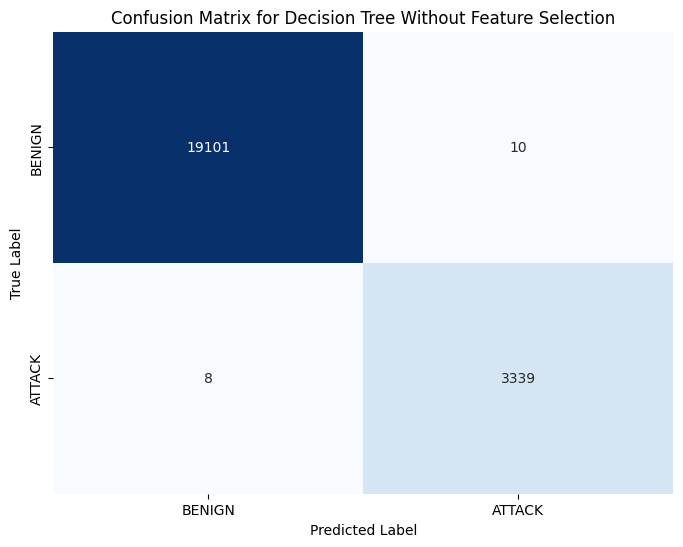

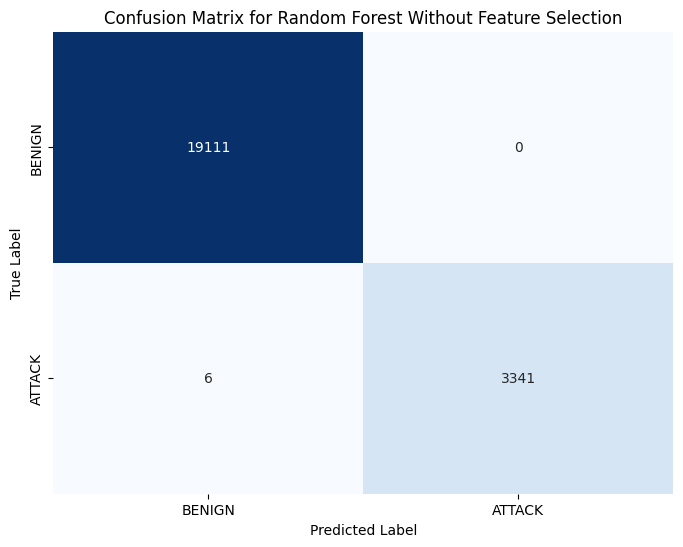

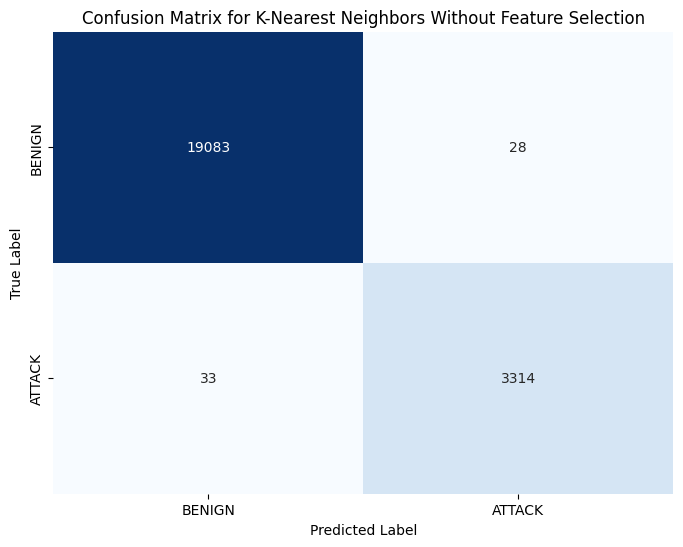

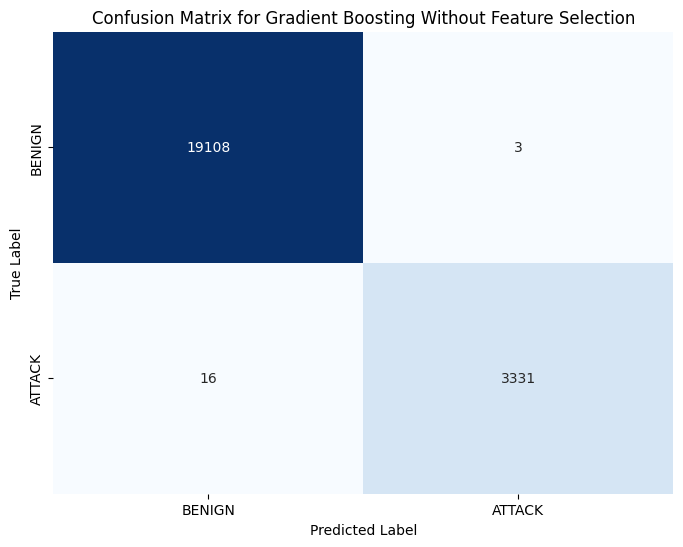

Top 20 features selected by SelectKBest with mutual information:
Index(['Destination Port', 'Total Length of Fwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Min', 'Fwd IAT Min', 'Fwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'Average Packet Size', 'Avg Fwd Segment Size', 'Fwd Header Length.1',
       'Subflow Fwd Bytes', 'Init_Win_bytes_forward'],
      dtype='object')


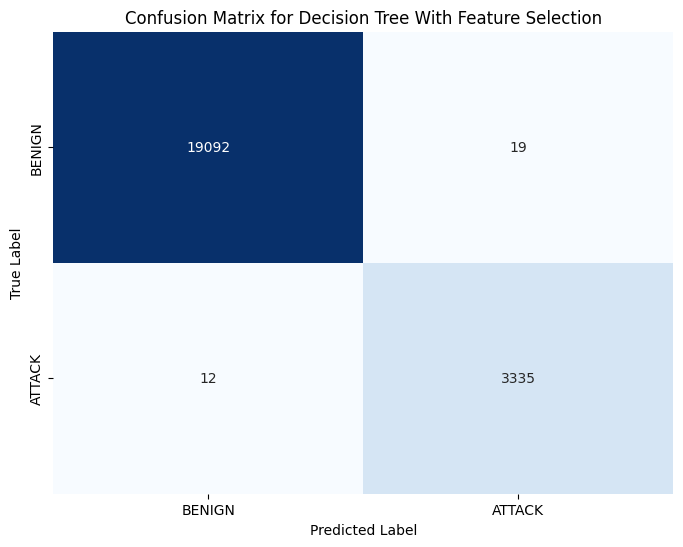

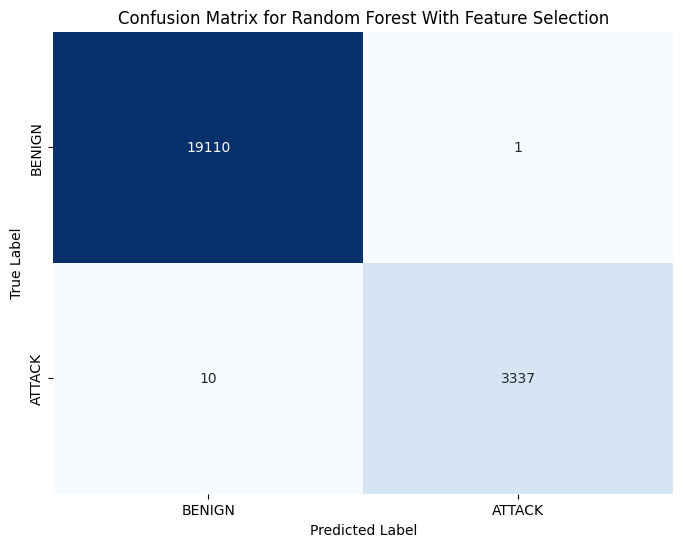

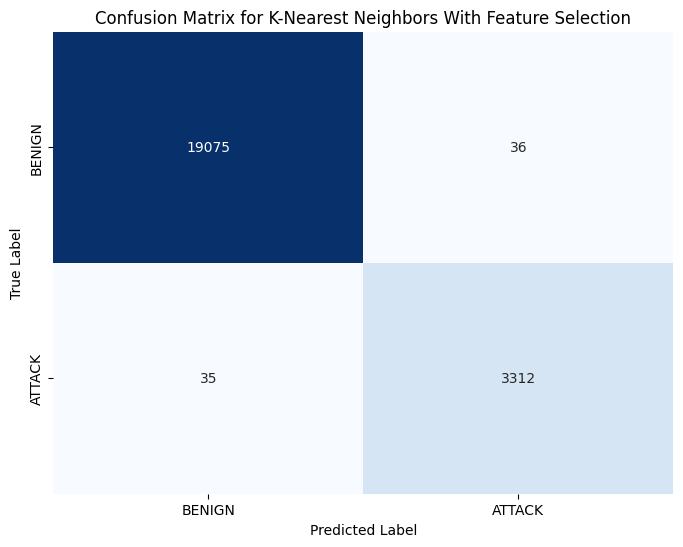

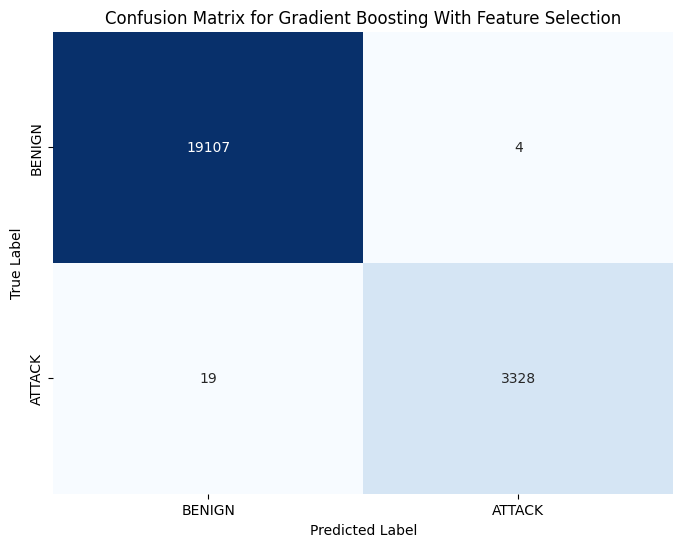

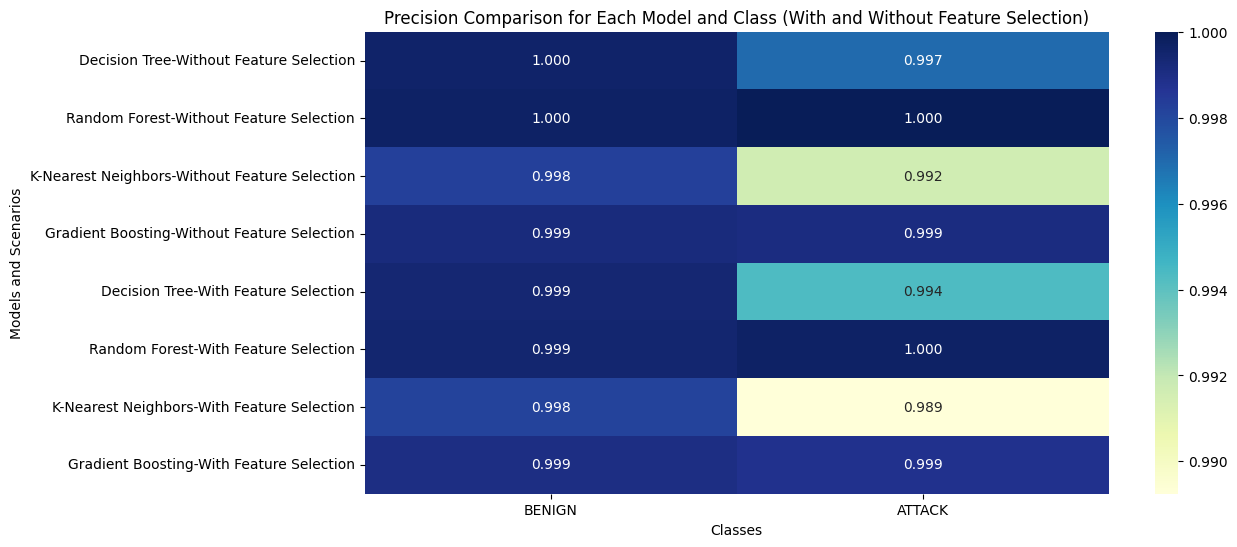

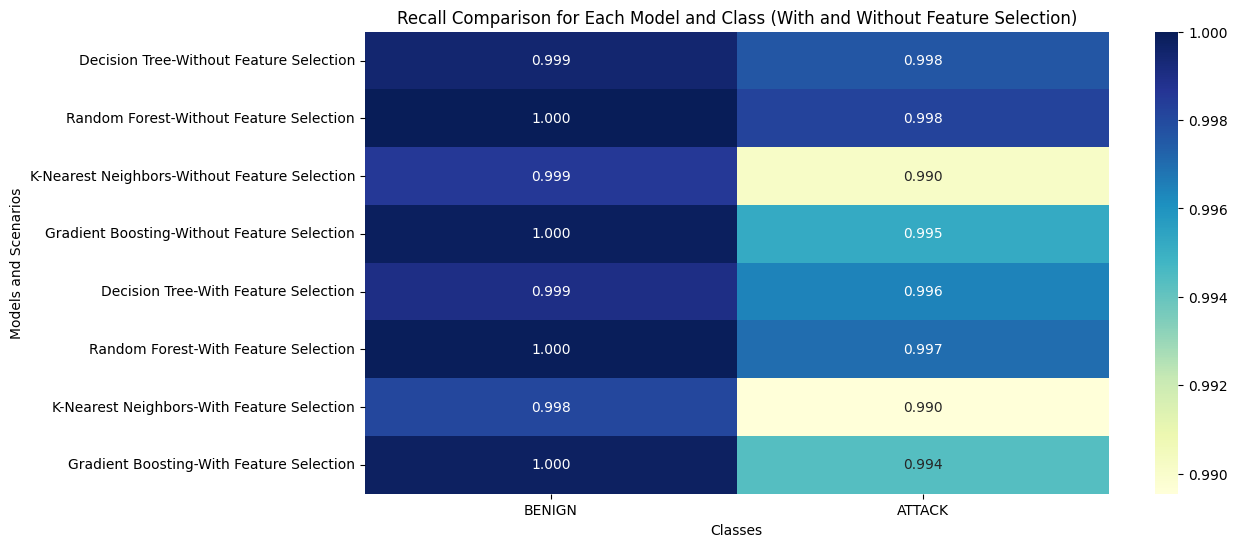

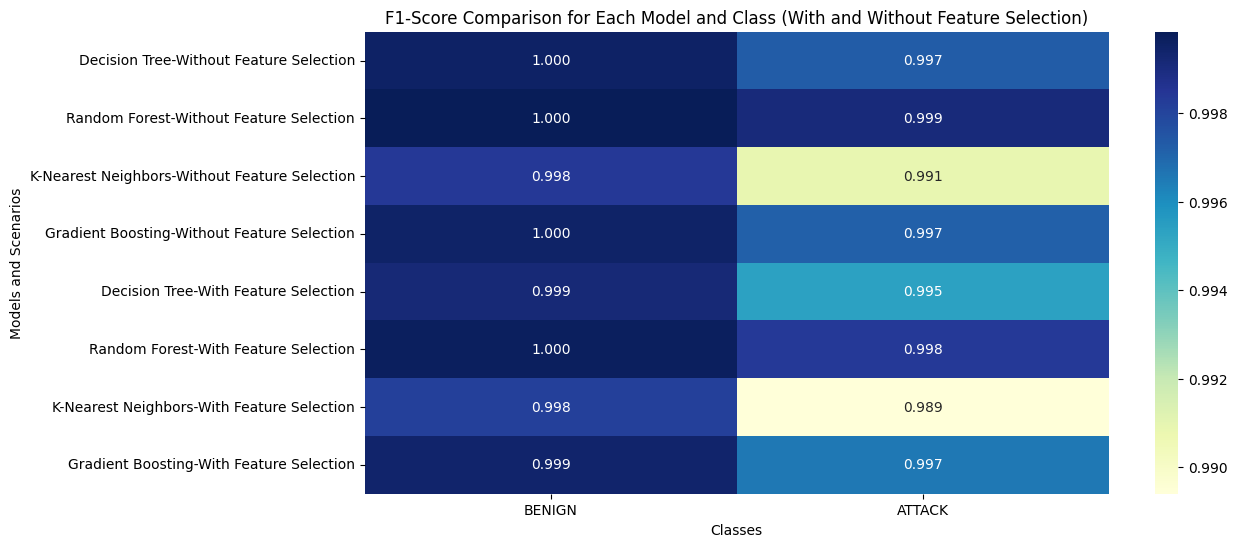

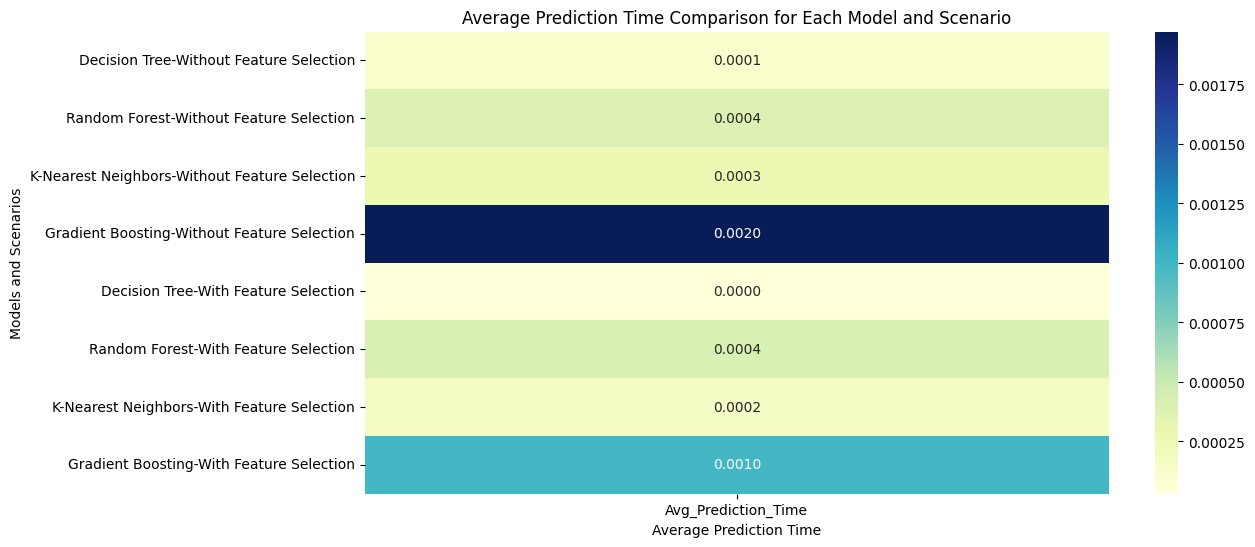

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import time  # Import time to measure prediction time

# Step 1: Load the Data
data = pd.read_csv('/kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv', nrows=75000)

# Strip leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Step 3: Filter for attacks with at least 1000 occurrences
label_counts = data['Label'].value_counts()
filtered_labels = label_counts[label_counts >= 1000].index
data = data[data['Label'].isin(filtered_labels)]

# Step 4: Handle Missing Values and Infinity Values
data_imputed = data.select_dtypes(include=['float64', 'int64'])

# Replace positive infinity, negative infinity, and excessively large values with NaN
data_imputed.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace large values (e.g., larger than 1e6) with NaN
data_imputed[data_imputed > 1e6] = np.nan

# Impute missing values (mean imputation for numeric columns)
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data_imputed))
data_imputed.columns = data.select_dtypes(include=['float64', 'int64']).columns

# Concatenate back the categorical columns
data_imputed = pd.concat([data_imputed, data.select_dtypes(include=['object']).reset_index(drop=True)], axis=1)

# Step 5: Convert Categorical Variables
# Convert "Label" to binary (0 = BENIGN, 1 = ATTACK)
data_imputed['Label'] = data_imputed['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

# Convert other categorical columns to numeric
label_encoders = {}
object_cols = data_imputed.select_dtypes(include=['object']).columns
for col in object_cols:
    le = LabelEncoder()
    data_imputed[col] = le.fit_transform(data_imputed[col])
    label_encoders[col] = le  # Save the encoder for future use

# Step 6: Prepare Features and Target Variable
X = data_imputed.drop(['Label'], axis=1)  # Features
y = data_imputed['Label']  # Target variable

# Get the class names mapping (only 0 and 1 for binary classification)
class_names = ['BENIGN', 'ATTACK']

# Step 7: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dictionary to store metrics for both scenarios
comparison_results = {
    'Model': [],
    'Scenario': [],  # With or Without Feature Selection
    'Avg_Prediction_Time': []  # For storing average prediction times
}

for class_name in class_names:
    comparison_results[f'Precision_{class_name}'] = []
    comparison_results[f'Recall_{class_name}'] = []
    comparison_results[f'F1_Score_{class_name}'] = []

# Models to Compare
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# ---- Without Feature Selection ----
for model_name, model in models.items():
    start_time = time.time()  # Start time for prediction
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()  # End time for prediction
    
    # Calculate average prediction time
    avg_pred_time = (end_time - start_time) / len(y_test)
    
    # Classification report
    class_report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    
    # Store results
    comparison_results['Model'].append(model_name)
    comparison_results['Scenario'].append("Without Feature Selection")
    comparison_results['Avg_Prediction_Time'].append(avg_pred_time)
    
    for class_name in class_names:
        if class_name in class_report:
            comparison_results[f'Precision_{class_name}'].append(class_report[class_name]['precision'])
            comparison_results[f'Recall_{class_name}'].append(class_report[class_name]['recall'])
            comparison_results[f'F1_Score_{class_name}'].append(class_report[class_name]['f1-score'])
        else:
            comparison_results[f'Precision_{class_name}'].append(0.0)
            comparison_results[f'Recall_{class_name}'].append(0.0)
            comparison_results[f'F1_Score_{class_name}'].append(0.0)
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.title(f"Confusion Matrix for {model_name} Without Feature Selection")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# ---- With Feature Selection ----
# Using SelectKBest with Mutual Information
selector = SelectKBest(mutual_info_classif, k=20)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Top 20 features selected by SelectKBest with mutual information:")
print(selected_features)

# Train models on selected features
for model_name, model in models.items():
    start_time = time.time()  # Start time for prediction
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    end_time = time.time()  # End time for prediction
    
    # Calculate average prediction time
    avg_pred_time = (end_time - start_time) / len(y_test)
    
    # Classification report
    class_report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    
    # Store results
    comparison_results['Model'].append(model_name)
    comparison_results['Scenario'].append("With Feature Selection")
    comparison_results['Avg_Prediction_Time'].append(avg_pred_time)
    
    for class_name in class_names:
        if class_name in class_report:
            comparison_results[f'Precision_{class_name}'].append(class_report[class_name]['precision'])
            comparison_results[f'Recall_{class_name}'].append(class_report[class_name]['recall'])
            comparison_results[f'F1_Score_{class_name}'].append(class_report[class_name]['f1-score'])
        else:
            comparison_results[f'Precision_{class_name}'].append(0.0)
            comparison_results[f'Recall_{class_name}'].append(0.0)
            comparison_results[f'F1_Score_{class_name}'].append(0.0)
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.title(f"Confusion Matrix for {model_name} With Feature Selection")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Convert comparison_results dictionary to DataFrame
comparison_df = pd.DataFrame(comparison_results)
comparison_df.set_index(['Model', 'Scenario'], inplace=True)

# Plot Heatmaps for Comparison
# Precision heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(comparison_df.filter(regex='Precision'), annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=class_names)
plt.title("Precision Comparison for Each Model and Class (With and Without Feature Selection)")
plt.xlabel("Classes")
plt.ylabel("Models and Scenarios")
plt.show()

# Recall heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(comparison_df.filter(regex='Recall'), annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=class_names)
plt.title("Recall Comparison for Each Model and Class (With and Without Feature Selection)")
plt.xlabel("Classes")
plt.ylabel("Models and Scenarios")
plt.show()

# F1-Score heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(comparison_df.filter(regex='F1_Score'), annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=class_names)
plt.title("F1-Score Comparison for Each Model and Class (With and Without Feature Selection)")
plt.xlabel("Classes")
plt.ylabel("Models and Scenarios")
plt.show()

# Average Prediction Time heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(comparison_df[['Avg_Prediction_Time']], annot=True, cmap='YlGnBu', fmt=".4f")
plt.title("Average Prediction Time Comparison for Each Model and Scenario")
plt.xlabel("Average Prediction Time")
plt.ylabel("Models and Scenarios")
plt.show()


In [48]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Step 1: Load the Data
data = pd.read_csv('/kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv', nrows=75000)

# Strip leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Step 3: Filter for attacks with at least 1000 occurrences
label_counts = data['Label'].value_counts()
filtered_labels = label_counts[label_counts >= 1000].index
data = data[data['Label'].isin(filtered_labels)]

# Step 4: Handle Missing Values and Infinity Values
data_imputed = data.select_dtypes(include=['float64', 'int64'])

# Replace positive infinity, negative infinity, and excessively large values with NaN
data_imputed.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace large values (e.g., larger than 1e6) with NaN
data_imputed[data_imputed > 1e6] = np.nan

# Impute missing values (mean imputation for numeric columns)
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data_imputed))
data_imputed.columns = data.select_dtypes(include=['float64', 'int64']).columns

# Concatenate back the categorical columns
data_imputed = pd.concat([data_imputed, data.select_dtypes(include=['object']).reset_index(drop=True)], axis=1)

# Step 5: Convert Categorical Variables
# Convert "Label" to binary (0 = BENIGN, 1 = ATTACK)
data_imputed['Label'] = data_imputed['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

# Convert other categorical columns to numeric
label_encoders = {}
object_cols = data_imputed.select_dtypes(include=['object']).columns
for col in object_cols:
    le = LabelEncoder()
    data_imputed[col] = le.fit_transform(data_imputed[col])
    label_encoders[col] = le  # Save the encoder for future use

# Step 6: Prepare Features and Target Variable
X = data_imputed.drop(['Label'], axis=1)  # Features
y = data_imputed['Label']  # Target variable

# Get the class names mapping (only 0 and 1 for binary classification)
class_names = ['BENIGN', 'ATTACK']

# Step 7: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Prediction Time (No Feature Selection): 5.62s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Prediction Time (With Feature Selection): 3.82s


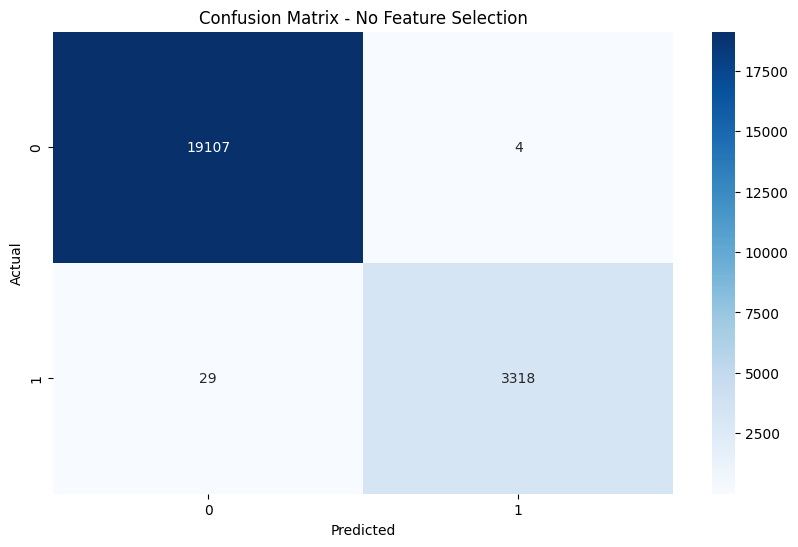

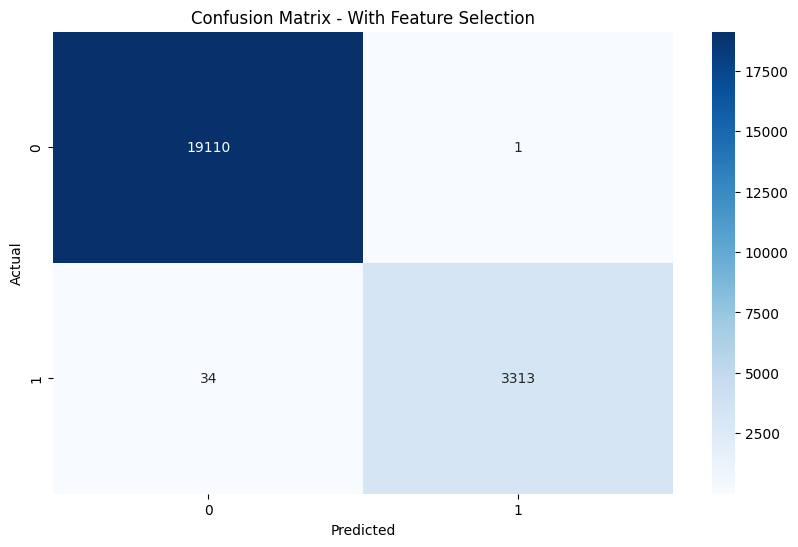

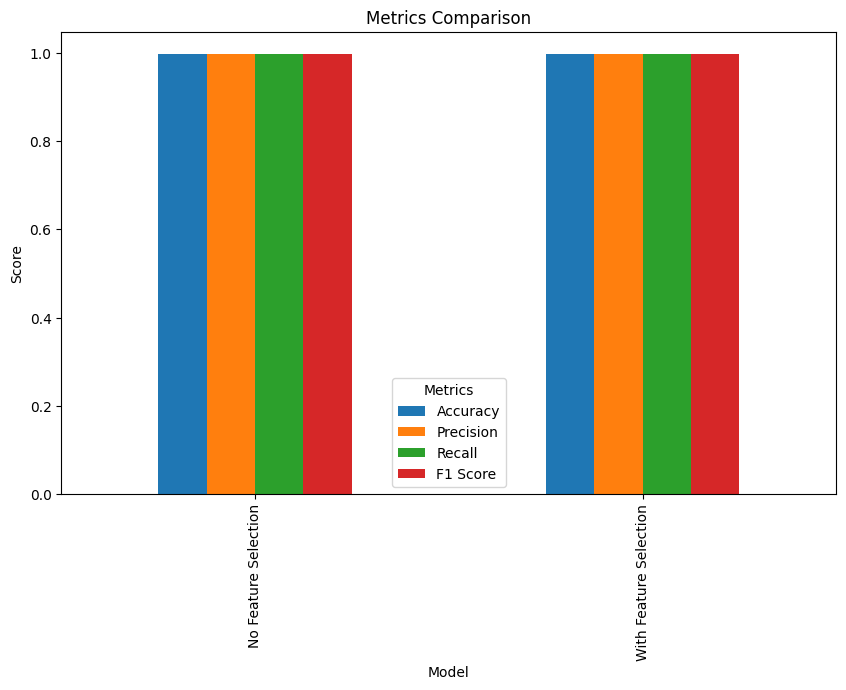

In [49]:
# Step 9: Define Models
lr_model = LogisticRegression(max_iter=1000)
knn_model = KNeighborsClassifier()
rf_model = RandomForestClassifier()

ensemble_model = VotingClassifier(estimators=[
    ('lr', lr_model),
    ('knn', knn_model),
    ('rf', rf_model)
], voting='hard')

# Without Feature Selection
ensemble_model.fit(X_train, y_train)
start_time = time.time()
y_pred_no_fs = ensemble_model.predict(X_test)
predict_time_no_fs = time.time() - start_time
print(f"Prediction Time (No Feature Selection): {predict_time_no_fs:.2f}s")

# Feature Selection
selector = SelectKBest(mutual_info_classif, k=20)
X_train_fs = selector.fit_transform(X_train, y_train)
X_test_fs = selector.transform(X_test)

ensemble_model.fit(X_train_fs, y_train)
start_time = time.time()
y_pred_fs = ensemble_model.predict(X_test_fs)
predict_time_fs = time.time() - start_time
print(f"Prediction Time (With Feature Selection): {predict_time_fs:.2f}s")

# Metrics Comparison
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'No Feature Selection': [
        accuracy_score(y_test, y_pred_no_fs),
        *precision_recall_fscore_support(y_test, y_pred_no_fs, average='weighted')[:3]
    ],
    'With Feature Selection': [
        accuracy_score(y_test, y_pred_fs),
        *precision_recall_fscore_support(y_test, y_pred_fs, average='weighted')[:3]
    ]
})

# Confusion Matrices
cm_no_fs = confusion_matrix(y_test, y_pred_no_fs)
cm_fs = confusion_matrix(y_test, y_pred_fs)

# Visualizations
plt.figure(figsize=(10, 6))
sns.heatmap(cm_no_fs, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - No Feature Selection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(cm_fs, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - With Feature Selection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot Metrics Comparison
metrics_df.set_index('Metric').T.plot(kind='bar', figsize=(10, 6))
plt.title("Metrics Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(title="Metrics")
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Prediction time without feature selection: 5.62 seconds
Average Time to Detect an Attack per Sample without Feature Selection: 0.000250 seconds


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Prediction time with feature selection: 3.93 seconds
Average Time to Detect an Attack per Sample with Feature Selection: 0.000175 seconds

Model Performance Metrics Comparison:
                           Accuracy  Precision    Recall  F1 Score  \
Without Feature Selection  0.998575   0.998575  0.998575  0.998573   
With Feature Selection     0.998486   0.998489  0.998486  0.998483   

                           Average Time to Detect (seconds)  
Without Feature Selection                          0.000250  
With Feature Selection                             0.000175  


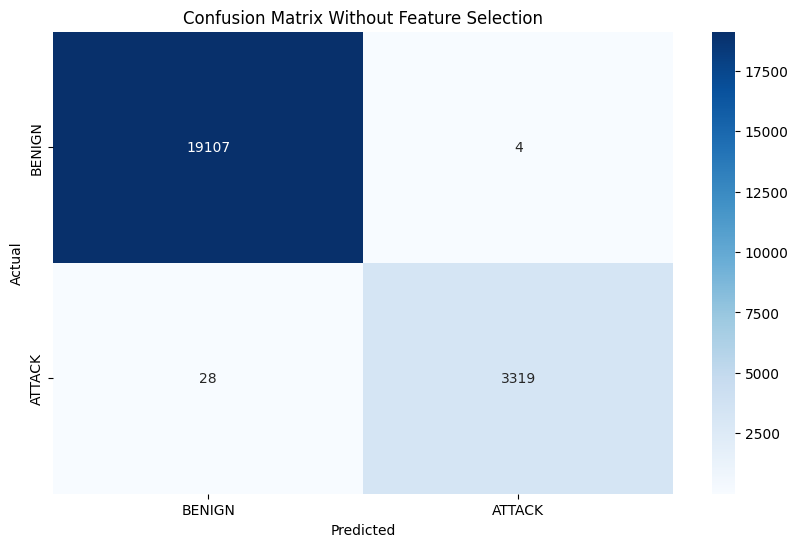

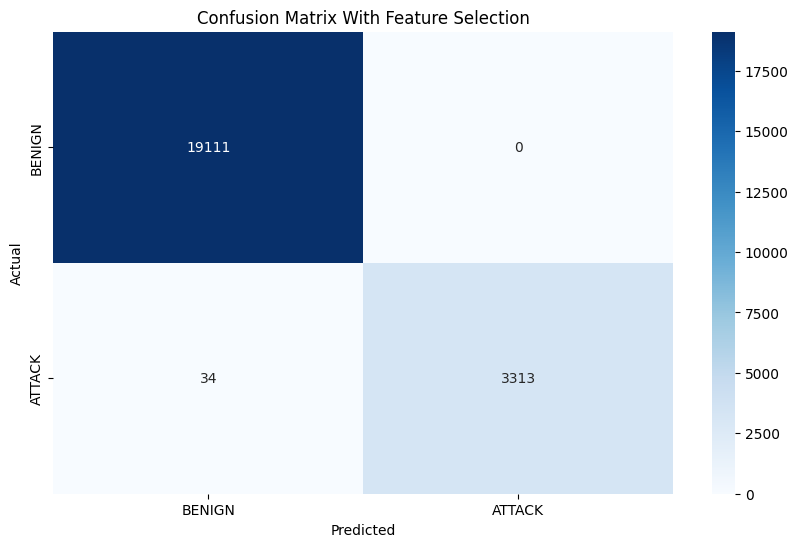

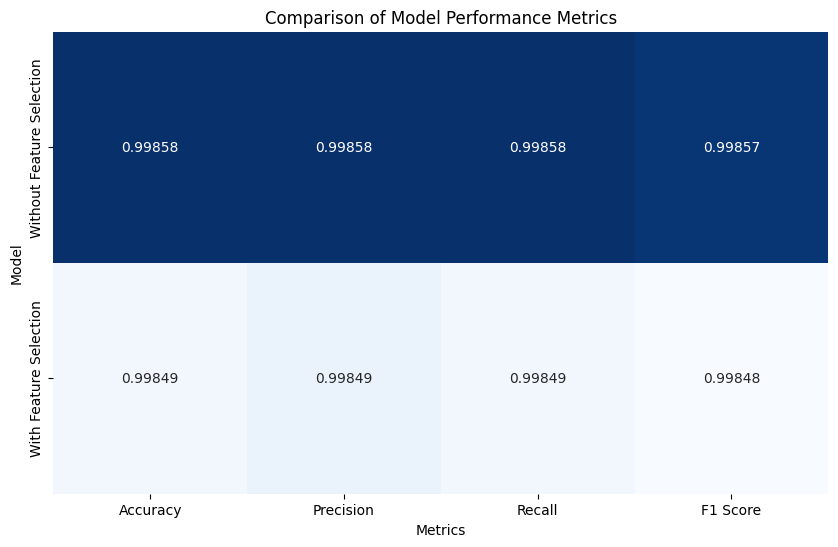

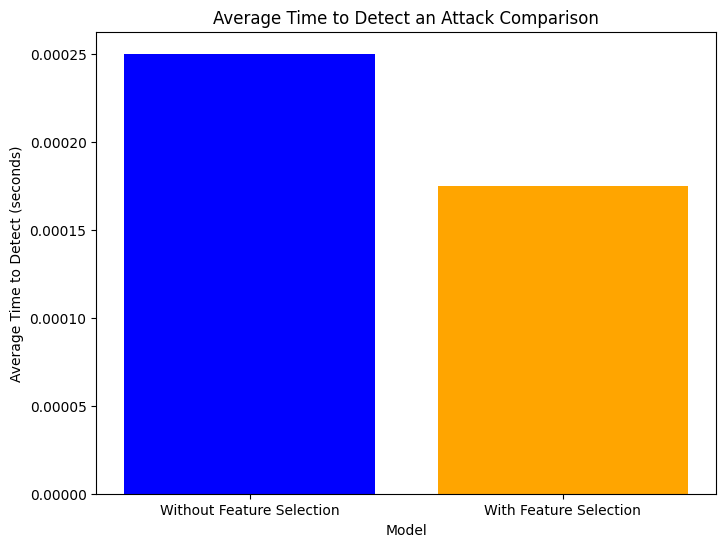

In [50]:
# ---- Without Feature Selection ----
# Fit the model without feature selection
ensemble_model.fit(X_train, y_train)

# Start the timer just before making predictions
predict_start = time.time()

# Make predictions without feature selection
y_pred_without_fs = ensemble_model.predict(X_test)

# Calculate and print the time taken for prediction
predict_time_without_fs = time.time() - predict_start
print(f"Prediction time without feature selection: {predict_time_without_fs:.2f} seconds")

# Calculate the time per attack detection (individual sample prediction time)
time_per_sample_without_fs = predict_time_without_fs / len(X_test)
print(f"Average Time to Detect an Attack per Sample without Feature Selection: {time_per_sample_without_fs:.6f} seconds")

# ---- With Feature Selection ----
# Feature selection
selector = SelectKBest(mutual_info_classif, k=20)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Fit the model on selected features
ensemble_model.fit(X_train_selected, y_train)

# Start the timer just before making predictions with selected features
predict_start = time.time()

# Make predictions with selected features
y_pred_with_fs = ensemble_model.predict(X_test_selected)

# Calculate and print the time taken for prediction
predict_time_with_fs = time.time() - predict_start
print(f"Prediction time with feature selection: {predict_time_with_fs:.2f} seconds")

# Calculate the time per attack detection (individual sample prediction time)
time_per_sample_with_fs = predict_time_with_fs / len(X_test_selected)
print(f"Average Time to Detect an Attack per Sample with Feature Selection: {time_per_sample_with_fs:.6f} seconds")

# --- Metrics Comparison ---
# Calculate and print metrics for comparison
accuracy_without_fs = accuracy_score(y_test, y_pred_without_fs)
precision_without_fs, recall_without_fs, f1_without_fs, _ = precision_recall_fscore_support(y_test, y_pred_without_fs, average='weighted')

accuracy_with_fs = accuracy_score(y_test, y_pred_with_fs)
precision_with_fs, recall_with_fs, f1_with_fs, _ = precision_recall_fscore_support(y_test, y_pred_with_fs, average='weighted')

# Create a dataframe for performance metrics comparison
metrics_df = pd.DataFrame({
    'Accuracy': [accuracy_without_fs, accuracy_with_fs],
    'Precision': [precision_without_fs, precision_with_fs],
    'Recall': [recall_without_fs, recall_with_fs],
    'F1 Score': [f1_without_fs, f1_with_fs],
    'Average Time to Detect (seconds)': [time_per_sample_without_fs, time_per_sample_with_fs]
}, index=['Without Feature Selection', 'With Feature Selection'])

print("\nModel Performance Metrics Comparison:")
print(metrics_df)

# --- Confusion Matrix Comparison ---
cm_without_fs = confusion_matrix(y_test, y_pred_without_fs)
cm_with_fs = confusion_matrix(y_test, y_pred_with_fs)

# Plot Confusion Matrix without Feature Selection
plt.figure(figsize=(10, 6))
sns.heatmap(cm_without_fs, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix Without Feature Selection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot Confusion Matrix with Feature Selection
plt.figure(figsize=(10, 6))
sns.heatmap(cm_with_fs, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix With Feature Selection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Plot Metrics Comparison ---
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']], annot=True, cmap="Blues", fmt=".5f", cbar=False)
plt.title("Comparison of Model Performance Metrics")
plt.ylabel('Model')
plt.xlabel('Metrics')
plt.show()

# --- Plot Average Time to Detect Comparison ---
plt.figure(figsize=(8, 6))
plt.bar(metrics_df.index, metrics_df['Average Time to Detect (seconds)'], color=['blue', 'orange'])
plt.title("Average Time to Detect an Attack Comparison")
plt.xlabel('Model')
plt.ylabel('Average Time to Detect (seconds)')
plt.show()


# **Data Analysis**

In [ ]:
df = pd.read_csv('/kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv')

In [16]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

Count of unique values in 'Label' column:
Label
BENIGN              440031
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: count, dtype: int64


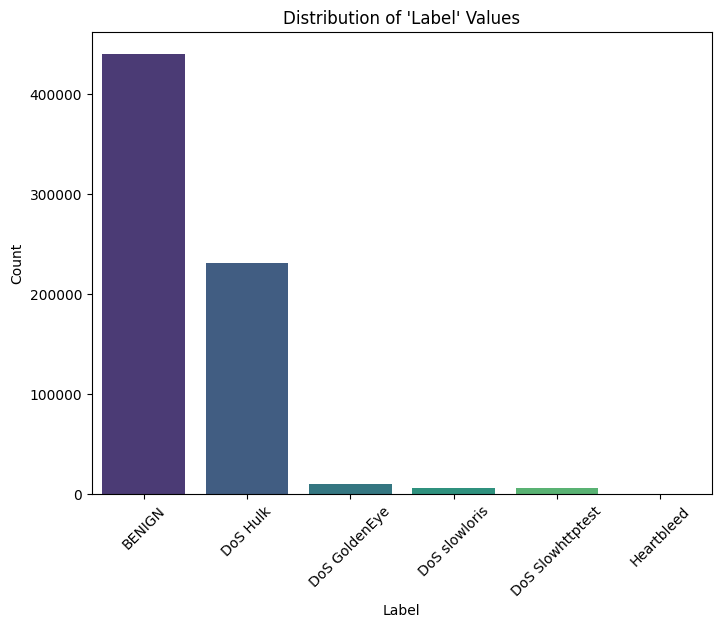

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Strip leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Count unique values in the 'Label' column
label_counts = df['Label'].value_counts()

# Print the counts of unique values
print("Count of unique values in 'Label' column:")
print(label_counts)
# Plot the distribution of 'Label' values
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Distribution of 'Label' Values")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [4]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,389,15206,17,12,3452,6660,1313,0,203.058823,425.778474,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,1092,9,6,3150,3152,1575,0,350.000000,694.509719,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
df.isnull().sum()

 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Length: 79, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692703 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             692703 non-null  int64  
 1    Flow Duration                692703 non-null  int64  
 2    Total Fwd Packets            692703 non-null  int64  
 3    Total Backward Packets       692703 non-null  int64  
 4   Total Length of Fwd Packets   692703 non-null  int64  
 5    Total Length of Bwd Packets  692703 non-null  int64  
 6    Fwd Packet Length Max        692703 non-null  int64  
 7    Fwd Packet Length Min        692703 non-null  int64  
 8    Fwd Packet Length Mean       692703 non-null  float64
 9    Fwd Packet Length Std        692703 non-null  float64
 10  Bwd Packet Length Max         692703 non-null  int64  
 11   Bwd Packet Length Min        692703 non-null  int64  
 12   Bwd Packet Length Mean       692703 non-nul